# Initialize

In [1]:
%pip install spylls
%pip install pagexml-tools
%pip install tqdm
%pip install pandas matplotlib seaborn scikit-learn graphviz openpyxl

%conda install --channel conda-forge pygraphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


In [3]:
from pathlib import Path

REPOSITORY_PATH = Path().parent.absolute()
REPOSITORY_PATH


PosixPath('/Users/carstenschnober/LAHTeR/workspace/nautilusocr')

# Read Ground Truth

In [4]:
# TODO: Download and decompress "VOC Ground truths of the trainingset in PAGE xml.7z" from https://zenodo.org/record/6414086


GROUND_TRUTH_PATH = REPOSITORY_PATH / "VOC Ground truths of the trainingset in PAGE xml"
assert (
    GROUND_TRUTH_PATH.is_dir()
), f"Directory containing ground truth not found at {GROUND_TRUTH_PATH.absolute()}"


GROUND_TRUTH_FILES = list(GROUND_TRUTH_PATH.glob("*.xml"))
assert len(GROUND_TRUTH_FILES) == 4735


In [5]:
from pagexml.parser import parse_pagexml_file
from tqdm import tqdm

pagexml_files = [parse_pagexml_file(file) for file in tqdm(GROUND_TRUTH_FILES)]


100%|██████████| 4735/4735 [02:17<00:00, 34.55it/s]


# General Functions

In [6]:
import logging
from typing import List


HYPHENS = {"-", "⸗", "="}


def get_tokens(text) -> List[str]:
    """Copied from features_epr.py"""
    if pd.isna(text):
        logging.warning("No text given.")
        return []
    tokens = list()

    new_token = ""
    for c in text:
        if c == " " and len(new_token) > 0:
            tokens.append(new_token)
            new_token = ""
        elif c == "\n" and len(new_token) > 0:
            if new_token[-1] in HYPHENS:
                new_token = new_token[:-1]
            else:
                tokens.append(new_token)
                new_token = ""
        else:
            new_token += c
    if len(new_token) > 0:
        tokens.append(new_token)

    for i, token in enumerate(tokens):
        if not token[-1].isalpha():
            tokens[i] = token[:-1]
        if not token[0].isalpha():
            tokens[i] = token[1:]

    return tokens


# Dictionary Lookup

## Hunspell

In [7]:
LANGUAGE = "nl"

HUNSPELL_DICT_PATH = REPOSITORY_PATH / "dicts"
assert HUNSPELL_DICT_PATH.is_dir()

SUFFIXES = [".aff", ".dic"]

assert HUNSPELL_DICT_PATH.is_dir()

assert all(
    (HUNSPELL_DICT_PATH / Path(LANGUAGE).with_suffix(suffix)).is_file()
    for suffix in [".aff", ".dic"]
)



In [8]:
from spylls.hunspell import Dictionary

hunspell = Dictionary.from_files(str(HUNSPELL_DICT_PATH / Path(LANGUAGE)))


In [9]:
from typing import List


def get_dict_score(tokens: List[str]):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += hunspell.lookup(token) * len(token)

        return matched_count / total_count
    else:
        return 0.0



In [10]:
tokens = ["Dit", "is", "een", "text"]

get_dict_score(tokens)


0.6666666666666666

## Ground Truth Dictionary

In [11]:
from pagexml.parser import parse_pagexml_file
from tqdm import tqdm
import random

words = set()

for pagexml in tqdm(pagexml_files):
    for line in pagexml.get_lines():
        if line.text is not None:
            words.update(get_tokens(line.text))

random.sample(words, 10)


100%|██████████| 4735/4735 [00:00<00:00, 5158.62it/s]
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/3298027077.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(words, 10)


['trevancoor',
 'lastpoort',
 'Donderd„h',
 'massieve',
 'Jaarlijksche',
 'tijd„na',
 'belijden',
 'Bade',
 'Opperhoofds',
 'napas']

In [12]:
VOC_DICT_OUTPUT_FILE = HUNSPELL_DICT_PATH / "nl_voc.txt"

# if VOC_DICT_OUTPUT_FILE.exists():
#     raise FileExistsError(VOC_DICT_OUTPUT_FILE)

# with open(VOC_DICT_OUTPUT_FILE, "wt") as f:
#     f.write("\n".join(sorted(words)))


In [13]:
def get_dict_score_gt(tokens):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += (token in words) * len(token)

        return matched_count / total_count
    else:
        return 0.0


# Train Tri-Gram Model

## Functions

In [14]:
from typing import List


NGRAM_LENGTH = 3


def get_ngrams(tokens) -> List[str]:
    """Copied, adapted from features_epr.py"""

    n_grams = list()
    for token in tokens:
        token_list = list(token)
        for i in range(0, len(token_list)):
            if not token[i].isalpha():
                token_list[i] = " "
        modified_token = "".join(token_list)
        splits = modified_token.split(" ")
        for split in splits:
            if split != "":
                for i in range(0, len(split) - NGRAM_LENGTH + 1):
                    n_grams.append(split[i : i + NGRAM_LENGTH].lower())
    return n_grams


In [15]:
def get_ngram_score(ngrams, lang_ngrams) -> float:
    """Copied from features_epr.py"""
    # TODO: this is very slow
    # TODO: check if this corresponds to equation 10 in the paper?

    if len(ngrams) == 0:
        return 0

    score = 0
    for ngram in ngrams:
        for i in range(0, len(lang_ngrams)):
            if ngram == lang_ngrams[i]:
                score += 1 - (1 / len(lang_ngrams) * i)
                break

    score = score / len(ngrams)
    return score


## Generate Model

In [16]:
from collections import Counter

from tqdm import tqdm


lang_trigrams = list()

for file in tqdm(pagexml_files, unit="file"):
    for line in pagexml.get_lines():
        tokens = get_tokens(line.text) if line.text else []
        lang_trigrams.extend(get_ngrams(tokens))

print(f"Total n-grams: {len(lang_trigrams)}")
print(f"Distinct n-grams: {len(set(lang_trigrams))}")
print(f"Most common n-grams: ")

Counter(lang_trigrams).most_common(10)


100%|██████████| 4735/4735 [00:02<00:00, 1872.56file/s]


Total n-grams: 2864675
Distinct n-grams: 312
Most common n-grams: 


[('ver', 56820),
 ('den', 52085),
 ('oor', 42615),
 ('ers', 37880),
 ('gen', 33145),
 ('nde', 33145),
 ('rde', 33145),
 ('der', 33145),
 ('voo', 28410),
 ('aar', 28410)]

In [17]:
import os

os.linesep.join([line.text for line in pagexml.get_lines()])


"386\nden 15: Meij 1782.\nDe koning vervolgens te kennen hebbende ge\n„geven hoe node het den Limbotters voorgekomen\nis wegens de van hen gevergde verhuizing\nnaar hun oude woonplaats Limbotto veront„\n„rust te worden: wierd goedgevonden en verstaan\nte repliceeren dat die verhuizing als nuttig\nvoor de Comp:e en naar het oordeel deezer Regee„\n„ring ook nuttig voor de Limbotters zelven\nalleen voorgeslagen en nimmer volstrekt\nop hen begeerd is; dat de Limbotters geen\nzin hebbende in de opbrake van Quandang\nals dan ook behoorden te zorgen dat de ge„\n„bouwen waar onder Comp:s dienaren moeten\nhuisvesten en hare effecten bewaard worden\nweder uit den vervallen staat waarinne men\nverneemd dat geraakt zijn, getrokken wierden\nen altoos 's Comp:s belangens in dien ooird moes„\nten in het oog houden welk laatste niet wel\nanders geschieden kan dan door eene vermeer„\n„derde goud Leverantie.\n/:onderstond:) Aldus gedaan en Gereselveerd tot\nTernaten in’t Kasteel Orange dato voorschreven

In [18]:
text = "Dit is eenasd teksthdgfhfgh"

tokens = get_tokens(text)
trigrams = get_ngrams(tokens)

get_ngram_score(trigrams, lang_trigrams)


0.1874795570178118

In [19]:
scores = Counter()
file_trigrams = list()

for line in pagexml.get_lines():
    text = line.text
    tokens = get_tokens(text)
    line_trigrams = get_ngrams(tokens)
    scores[text] = get_ngram_score(line_trigrams, lang_trigrams)

    file_trigrams.extend(line_trigrams)

scores.most_common()



[('den 15: Meij 1782.', 0.9999996509202616),
 ('De koning vervolgens te kennen hebbende ge', 0.9999952874235297),
 ('hebbende', 0.9999924947856215),
 ('„geven hoe node het den Limbotters voorgekomen', 0.9999875308717395),
 ('is wegens de van hen gevergde verhuizing', 0.9999846230375171),
 ('naar hun oude woonplaats Limbotto veront„', 0.9999767634313173),
 ('„rust te worden: wierd goedgevonden en verstaan', 0.9999710822344593),
 ('op hen begeerd is; dat de Limbotters geen', 0.9999699586083833),
 ('„ring ook nuttig voor de Limbotters zelven', 0.9999696300627472),
 ('te repliceeren dat die verhuizing als nuttig', 0.9999643065967342),
 ('voor de Comp:e en naar het oordeel deezer Regee„', 0.9999619135632636),
 ('als dan ook behoorden te zorgen dat de ge„', 0.9999535258508093),
 ('Limbotters van Quandang is wel', 0.9999528306003298),
 ('voorgeslagen maar geen zin', 0.9999492205340339),
 ('zin hebbende in de opbrake van Quandang', 0.9999475829213657),
 ('alleen voorgeslagen en nimmer volstrek

In [20]:
get_ngram_score(file_trigrams, lang_trigrams)


0.9999367438664196

# Garbage Token Detection

## Functions

In [21]:
EPR_RULE1 = 21
EPR_RULE2 = 3
EPR_RULE3 = 4
EPR_RULE4 = 6
EPR_RULE5 = 8
EPR_RULE9 = 2

VOWELS = "aäàáâǎeéèêëěiîïíìıoöôòóǒuüûùúǔ"


def get_garbage_score(tokens):
    """Copied from features_epr.py"""

    issues = 0

    if len(tokens) == 0:
        return 0

    for token in tokens:

        # rule1
        if len(token) >= EPR_RULE1:
            issues += 1
            continue

        vowel_count = 0
        consonant_count = 0
        lower_case_count = 0
        upper_case_count = 0
        special_char_count = 0
        non_outer_special_chars = set()
        alpha = True
        last_char = None
        repitition_streak = 0
        vowel_streak = 0
        consonant_streak = 0
        go_to_next_token = False
        for i in range(0, len(token)):
            go_to_next_token = False
            char = token[i]

            # collect token info
            if char.isalpha():
                if char.lower() in VOWELS:
                    vowel_count += 1
                    vowel_streak += 1
                    consonant_streak = 0
                else:
                    consonant_count += 1
                    consonant_streak += 1
                    vowel_streak = 0
                if char.isupper():
                    upper_case_count += 1
                else:
                    lower_case_count += 1
            elif char.isalnum():
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
            else:
                special_char_count += 1
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
                if i != 0 and i != len(token) - 1:
                    non_outer_special_chars.add(char)

            # rule 3
            if vowel_streak >= EPR_RULE3:
                issues += 1
                go_to_next_token = True
                break

            # rule 4
            if consonant_streak >= EPR_RULE4:
                issues += 1
                go_to_next_token = True
                break

            if last_char != None and char == last_char:
                repitition_streak += 1

                # rule 2
                if repitition_streak >= EPR_RULE2:
                    issues += 1
                    go_to_next_token = True
                    break
            else:
                repitition_streak = 0
            last_char = char

        if go_to_next_token:
            continue

        if alpha and vowel_count > 0 and consonant_count > 0:
            # rule 5
            if vowel_count * EPR_RULE5 < consonant_count:
                issues += 1
                continue
            # rule 5
            if consonant_count * EPR_RULE5 < vowel_count:
                issues += 1
                continue

        # rule 6
        if lower_case_count > 0 and upper_case_count > lower_case_count:
            issues += 1
            continue

        # rule 7
        if (
            upper_case_count > 0
            and token[0].islower()
            and token[len(token) - 1].islower()
        ):
            issues += 1
            continue

        # rule 8
        regular_chars = len(token) - special_char_count
        if special_char_count >= regular_chars and regular_chars > 0:
            issues += 1
            continue

        # rule 9
        if len(non_outer_special_chars) >= EPR_RULE9:
            issues += 1
            continue

    return issues / len(tokens)



In [22]:
get_garbage_score(get_tokens(text))


0.0

# Publication Year Consideration

In [23]:
# TODO: Fill in correct year range
MIN_YEAR = 1500
MAX_YEAR = 1800


def scale_year(year):
    """Copied from features_epr.py"""

    scaled_year = (year - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    scaled_year = max(min(1.0, scaled_year), 0.0)
    return scaled_year


In [24]:
scale_year(1800)


1.0

# Scoring

In [25]:
DATA_DIR = REPOSITORY_PATH / "data"
assert DATA_DIR.is_dir()


In [26]:
JUDGEMENTS_FILE = DATA_DIR / "limited2 review overview 20220713.csv"
assert JUDGEMENTS_FILE.is_file()


In [27]:
PAGES_DIR = DATA_DIR / "page"
assert PAGES_DIR.is_dir()


## Read Judgements

In [28]:
import pandas as pd

judgements = pd.read_csv(JUDGEMENTS_FILE, index_col=0).rename(
    {"Unnamed: 11": "url"}, axis="columns"
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN


In [29]:
judgements[["Ranking Kay", "Ranking Maartje"]].corr()


,Ranking Kay,Ranking Maartje
Ranking Kay,1.000000,0.626003
Ranking Maartje,0.626003,1.000000


### Read Error Types

In [30]:
ERROR_TYPOLOGY_FILE = DATA_DIR / "Error Typology limited2 MH.xlsx"
assert ERROR_TYPOLOGY_FILE.is_file()

In [31]:
error_types = pd.read_excel(
    ERROR_TYPOLOGY_FILE, usecols=["Filename", "Line No", "Error Code"]
).dropna(subset="Error Code")
error_types


,Filename,Line No,Error Code
0,NL-HaNA_1.04.02_1108_1273,06-01,4.7
1,NL-HaNA_1.04.02_1108_1273,10-38,4.7
2,NL-HaNA_1.04.02_1108_1273,-,4.3
3,NL-HaNA_1.04.02_1636_0070,3-25,3.2
4,NL-HaNA_1.04.02_1636_0070,4-2,4.7
...,...,...,...
143,NL-HaNA_1.04.02_3764_0415,-,3.2
144,NL-HaNA_1.04.02_3970_0021,1-1,4.8
145,NL-HaNA_1.04.02_3970_0021,4-1,2.4.1
146,NL-HaNA_1.04.02_3970_0021,4-1,1.2.2


In [32]:
error_types["category"] = error_types["Error Code"].apply(lambda x: x.split(".")[0])
error_types

,Filename,Line No,Error Code,category
0,NL-HaNA_1.04.02_1108_1273,06-01,4.7,4
1,NL-HaNA_1.04.02_1108_1273,10-38,4.7,4
2,NL-HaNA_1.04.02_1108_1273,-,4.3,4
3,NL-HaNA_1.04.02_1636_0070,3-25,3.2,3
4,NL-HaNA_1.04.02_1636_0070,4-2,4.7,4
...,...,...,...,...
143,NL-HaNA_1.04.02_3764_0415,-,3.2,3
144,NL-HaNA_1.04.02_3970_0021,1-1,4.8,4
145,NL-HaNA_1.04.02_3970_0021,4-1,2.4.1,2
146,NL-HaNA_1.04.02_3970_0021,4-1,1.2.2,1


In [33]:
judgements = judgements.join(
    error_types.groupby("Filename")
    .value_counts(subset=["category"])
    .unstack(fill_value=0)
    .rename(lambda x: "error_type_" + x, axis="columns"),
    on="Filename",
    lsuffix="error_type_",
)
judgements



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN


## Read and Process Pages

In [34]:
def tokenize_pagexml(path: Path) -> List[str]:
    parse_pagexml_file(path).text


In [35]:
judgements["path"] = judgements.Filename.apply(lambda f: PAGES_DIR / (f + ".xml"))
assert judgements["path"].apply(Path.is_file).all()
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/nautil...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...


In [36]:
judgements["pagexml"] = judgements.path.apply(parse_pagexml_file)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....


In [37]:
judgements["lines"] = judgements.pagexml.apply(
    lambda pagexml: [line.text for line in pagexml.get_lines() if line.text]
)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors..."
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon..."
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p..."
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ..."


In [38]:
import os

judgements["text"] = judgements.lines.apply(lambda l: os.linesep.join(l))
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh..."


In [39]:
judgements["tokens"] = judgements.text.apply(get_tokens)
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.0,0.0,0.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,..."
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co..."
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An..."
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van..."
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek...","[hoe, hij, dat, wijs, en, daar, op, ten, antwo..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh...","[verkeerd, hun, leven, verbeuid, hebben, en, n..."


In [40]:
judgements.iloc[judgements.Som.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2659_0164.j...,"[32-, L O 1 V L L 2C, der t‛act van de traneve...",32-\nL O 1 V L L 2C\nder t‛act van de tranever...,"[2L, O, , V, L, L, C, der, t‛act, van, de, tra..."
93,94,Goed!,NaN,0,goed,NaN,1,1,NL-HaNA_1.04.02_1851_0707,1851,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0707.j...,"[Heden den 3: Februarij 1714:, Compareerden vo...",Heden den 3: Februarij 1714:\nCompareerden voo...,"[Heden, den, :, Februarij, 714:, Compareerden,..."
187,188,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_2646_0018,2646,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2646_0018.j...,[],,[]
33,34,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1306_0327,1306,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1306_0327.j...,"[ve e, eerere, 3„ 6 „]",ve e\neerere\n3„ 6 „,"[ve, e, eerere, „, , ]"
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1967_1068,1967,...,2.0,1.0,1.0,3.0,0.0,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1967_1068.j...,"[19/6, eeeee, „ - 3: . .]",19/6\neeeee\n„ - 3: . .,"[9/6, eeeee, , , :, , ]"
108,109,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1968_0696,1968,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1968_0696.j...,[1:],1:,[:]
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2036_0307.j...,"[uytslag van saken tot tyd en, inslateur, S —,...",uytslag van saken tot tyd en\ninslateur\nS —\n...,"[uytslag, van, saken, tot, tyd, en, inslateur,..."
439,440,Slecht,Regelvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_9751_0010,9751,...,NaN,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9751_0010.j...,[Den 30.' maart zijn de kleeden 'smorgens vers...,Den 30.' maart zijn de kleeden 'smorgens versc...,"[Den, 0.', maart, zijn, de, kleeden, smorgens,..."


## Compute Features

### Dictionary Scores

In [41]:
judgements["dict_score"] = judgements.tokens.apply(get_dict_score)
judgements.iloc[judgements.dict_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_2,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens,dict_score
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10633_0002....,[],,[],0.000000
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10124_0230....,[],,[],0.000000
24,25,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1269_1040,1269,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1269_1040.j...,[],,[],0.000000
434,435,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9534_0129,9534,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9534_0129.j...,[],,[],0.000000
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,304,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_4071_1018,4071,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4071_1018.j...,"[p„s,, . Co, Sententie van, Jacobus de Bruy]","p„s,\n. Co\nSententie van\nJacobus de Bruy","[p„s, , Co, Sententie, van, Jacobus, de, Bruy]",0.766667
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0827.j...,[1004],1004,[004],1.000000
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,...,NaN,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]",1.000000


In [42]:
judgements["dict_score_gt"] = judgements.tokens.apply(get_dict_score_gt)
judgements.iloc[judgements.dict_score_gt.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_3,error_type_4,error_type_5,path,pagexml,lines,text,tokens,dict_score,dict_score_gt
66,67,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1578_0938,1578,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1578_0938.j...,[],,[],0.000000,0.0
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000,0.0
52,53,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1443_0212,1443,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1443_0212.j...,[],,[],0.000000,0.0
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10633_0002....,[],,[],0.000000,0.0
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10124_0230....,[],,[],0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000,1.0
254,255,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_3389_0782,3389,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3389_0782.j...,"[ee en, teene]",ee en\nteene,"[ee, en, teene]",0.222222,1.0
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0827.j...,[1004],1004,[004],1.000000,1.0
417,418,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_9342_0377,9342,...,NaN,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9342_0377.j...,"[11, ee e ee]",11\nee e ee,"[1, ee, e, ee]",0.333333,1.0


<Axes: xlabel='dict_score', ylabel='dict_score_gt'>

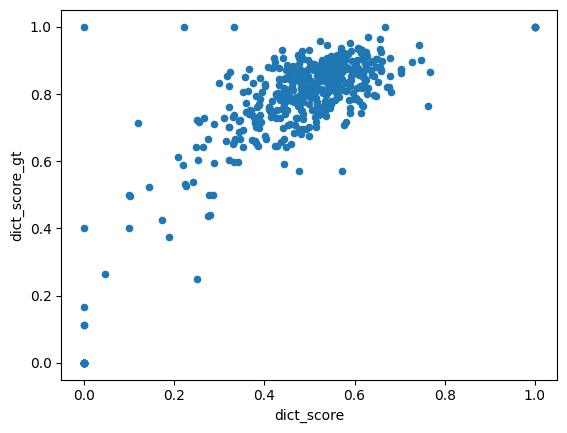

In [43]:
judgements.plot(kind="scatter", x="dict_score", y="dict_score_gt")
# TODO: dot size per text length


### Tri-gram Scores

In [44]:
MAX_N_GRAMS = 1000


judgements["n_gram_score"] = judgements.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
judgements.iloc[judgements.n_gram_score.sort_values().index]



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_4,error_type_5,path,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score
262,263,Slecht,NaN,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3511_0260,3511,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3511_0260.j...,"[6./, ƒ: 1 1, 1176. 8 7or: Aan t Compl: Bengal...",6./\nƒ: 1 1\n1176. 8 7or: Aan t Compl: Bengale...,"[./, ƒ, , , 176., , or:, Aan, t, Compl, Bengal...",0.289157,0.594378,0.000000
316,317,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_4418_0340,4418,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4418_0340.j...,[ee eee],ee eee,"[ee, eee]",0.000000,0.400000,0.000000
279,280,Goed,NaN,1,medium,leeg; transcriptie die er niet hoort,2,3,NL-HaNA_1.04.02_3652_0825,3652,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3652_0825.j...,[eee e],eee e,"[eee, e]",0.250000,0.250000,0.000000
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000,0.000000,0.000000
319,320,Goed,NaN,1,medium,transcriptie,2,3,NL-HaNA_1.04.02_4444_0535,4444,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4444_0535.j...,"[Aan de Edele Achtbaare, Heeren Bewindhebberen...",Aan de Edele Achtbaare\nHeeren Bewindhebberen\...,"[Aan, de, Edele, Achtbaare, Heeren, Bewindhebb...",0.550000,0.816667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1988_1109,1988,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1988_1109.j...,[Van nadien het van oudsher een gebruijk gewee...,Van nadien het van oudsher een gebruijk gewees...,"[Van, nadien, het, van, oudsher, een, gebruijk...",0.655963,0.963303,0.228500
336,337,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_7893_0137,7893,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7893_0137.j...,"[Iavas Oostcust den 27:e Iunij 1743, Mijn heer...",Iavas Oostcust den 27:e Iunij 1743\nMijn heer....,"[Iavas, Oostcust, den, 7:e, Iunij, 743, Mijn, ...",0.502216,0.874446,0.231342
43,44,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1400_1066,1400,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1400_1066.j...,[Ick op mijn aenkomst vondleggen wel dertig pr...,Ick op mijn aenkomst vondleggen wel dertig pra...,"[Ick, op, mijn, aenkomst, vondleggen, wel, der...",0.678212,0.853631,0.232404
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,...,NaN,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000,1.000000,0.540000


### Garbage Token Scores

In [45]:
judgements["garbage_score"] = judgements.tokens.apply(get_garbage_score)
judgements.iloc[judgements.garbage_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,error_type_5,path,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
378,379,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8831_0064,8831,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8831_0064.j...,"[Van Cormandel den 18 aug 1719, tot fiscael en...",Van Cormandel den 18 aug 1719\ntot fiscael en\...,"[Van, Cormandel, den, 8, aug, 719, tot, fiscae...",0.534548,0.778284,0.161511,0.000000
85,86,Goed?,Heel veel van andere pagina's,0,slecht,NaN,3,3,NL-HaNA_1.04.02_1785_0028,1785,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1785_0028.j...,[agtb: gunst te continueren over den raad van ...,agtb: gunst te continueren over den raad van j...,"[agtb, gunst, te, continueren, over, den, raad...",0.742475,0.944482,0.192984,0.000000
387,388,Slecht,Tekst en regelherkenning,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_8960_0003,8960,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8960_0003.j...,"[ommis, Ge, Van, e Ven, M, Ce, Ge Ce, V: Cr, C...",ommis\nGe\nVan\ne Ven\nM\nCe\nGe Ce\nV: Cr\nCe...,"[ommis, Ge, Van, e, Ven, M, Ce, Ge, Ce, V, Cr,...",0.404762,0.666667,0.000000,0.000000
131,132,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2155_0281,2155,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2155_0281.j...,"[en palicoll buijten kennisse van, mooren teli...",en palicoll buijten kennisse van\nmooren telic...,"[en, palicoll, buijten, kennisse, van, mooren,...",0.524217,0.849003,0.098145,0.000000
388,389,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8970_1586,8970,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8970_1586.j...,"[Van Ceijlon onder dato 25 Septemb:r 1716, p. ...",Van Ceijlon onder dato 25 Septemb:r 1716\np. ....,"[Van, Ceijlon, onder, dato, 5, Septemb:r, 716,...",0.469930,0.728671,0.054318,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,437,Leeg,NaN,0,medium,leeg; 1 transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9594_0147,9594,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9594_0147.j...,"[6e 8, 9, eeeee, ve ee]",6e 8\n9\neeeee\nve ee,"[e, , , eeeee, ve, ee]",0.100000,0.500000,0.000000,0.166667
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e...",0.173448,0.426124,0.048968,0.178344
432,433,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9467_0563,9467,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9467_0563.j...,"[eeere, eeeee, eve e en]",eeere\neeeee\neve e en,"[eeere, eeeee, eve, e, en]",0.187500,0.375000,0.194800,0.200000
337,338,Slecht,Layout,3,medium,leesvolgorde; ditto,2,5,NL-HaNA_1.04.02_7950_0317,7950,...,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7950_0317.j...,"[Baguala, ten overstaan van dies Restherdiers,...","Baguala, ten overstaan van dies Restherdiers, ...","[Baguala, ten, overstaan, van, dies, Restherdi...",0.321101,0.700584,0.036578,0.211009


### Publication Year

Ground truth missing year information

### Column Width

In [46]:
from statistics import mean


def average_line_length(page: pagexml) -> float:
    lengths = [len(line.text) for line in page.get_lines() if line.text is not None]
    return mean(lengths) if lengths else 0



In [47]:
judgements["column_width"] = judgements.pagexml.apply(average_line_length)
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,path,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,column_width
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he...",0.378567,0.712289,0.084309,0.002915,47.534884
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,...",0.428164,0.793615,0.098740,0.005540,44.872340
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co...",0.315423,0.659038,0.078552,0.003407,53.462687
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An...",0.321451,0.603502,0.067127,0.017182,36.576923
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e...",0.173448,0.426124,0.048968,0.178344,5.225490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van...",0.569307,0.935644,0.120795,0.008197,31.304348
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos...",0.604352,0.892186,0.174786,0.000000,35.382353
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek...","[hoe, hij, dat, wijs, en, daar, op, ten, antwo...",0.599502,0.786070,0.148869,0.015707,18.358491
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh...","[verkeerd, hun, leven, verbeuid, hebben, en, n...",0.557219,0.818182,0.172606,0.014085,35.181818


### Words per Text Region

In [48]:
def words_per_region(page: pagexml) -> float:
    words = [region.stats["words"] for region in page.text_regions]
    return mean(words) if words else 0


In [49]:
judgements["words_per_region"] = judgements.pagexml.apply(words_per_region)
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,pagexml,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,column_width,words_per_region
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he...",0.378567,0.712289,0.084309,0.002915,47.534884,114.333333
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,...",0.428164,0.793615,0.098740,0.005540,44.872340,120.333333
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co...",0.315423,0.659038,0.078552,0.003407,53.462687,196.000000
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An...",0.321451,0.603502,0.067127,0.017182,36.576923,36.375000
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e...",0.173448,0.426124,0.048968,0.178344,5.225490,2.661017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van...",0.569307,0.935644,0.120795,0.008197,31.304348,122.000000
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos...",0.604352,0.892186,0.174786,0.000000,35.382353,201.000000
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek...","[hoe, hij, dat, wijs, en, daar, op, ten, antwo...",0.599502,0.786070,0.148869,0.015707,18.358491,63.666667
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh...","[verkeerd, hun, leven, verbeuid, hebben, en, n...",0.557219,0.818182,0.172606,0.014085,35.181818,53.250000


## Preprocessing and Filtering

In [50]:
judgements["quality"] = np.ceil(judgements.Som / 2).astype(int)
judgements.iloc[judgements.quality.sort_values().index]



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,column_width,words_per_region,quality
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,...,"[32-, L O 1 V L L 2C, der t‛act van de traneve...",32-\nL O 1 V L L 2C\nder t‛act van de tranever...,"[2L, O, , V, L, L, C, der, t‛act, van, de, tra...",0.580477,0.716095,0.112926,0.006452,32.288462,31.500000,0
151,152,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2314_1588,2314,...,"[: Van, Aldus gepasseert en besloten tot Timor...",: Van\nAldus gepasseert en besloten tot Timor ...,"[, Van, Aldus, gepasseert, en, besloten, tot, ...",0.587192,0.872906,0.072632,0.019139,36.176471,41.800000,1
392,393,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8990_0164,8990,...,"[150., van mallebaer onder p„mo novemb: 1703.,...",150.\nvan mallebaer onder p„mo novemb: 1703.\n...,"[50., van, mallebaer, onder, p„mo, novemb, 703...",0.439437,0.929577,0.081279,0.019231,38.909091,104.000000,1
180,181,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2579_0251,2579,...,"[Van, den soldaet Willem Luijcke van, Gellenbe...",Van\nden soldaet Willem Luijcke van\nGellenbee...,"[Van, den, soldaet, Willem, Luijcke, van, Gell...",0.554483,0.856552,0.133039,0.011236,20.409091,29.666667,1
181,182,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2585_0213,2585,...,[Van Cabo De goede hoop onder dato 26 feb: 174...,Van Cabo De goede hoop onder dato 26 feb: 1742...,"[Van, Cabo, De, goede, hoop, onder, dato, 6, f...",0.589958,0.837866,0.091613,0.009009,32.611111,111.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,373,Slecht,Regio-indeling,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_8784_0928,8784,...,"[Van Bengale Den 31:' maart A:o 1731;, P„r Tra...",Van Bengale Den 31:' maart A:o 1731;\nP„r Tran...,"[Van, Bengale, Den, 1:', maart, A:o, 731;, P„r...",0.414695,0.731009,0.032912,0.035088,30.805556,57.000000,3
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,...,[164.— „ 2. -. Packen Per Transport met P o/ 1...,164.— „ 2. -. Packen Per Transport met P o/ 15...,"[64.—, , ., ., Packen, Per, Transport, met, P,...",0.432035,0.877186,0.061857,0.054363,37.750000,53.769231,3
219,220,Slecht,NaN,3,medium,layout; leesvolgorde,2,5,NL-HaNA_1.04.02_3018_0173,3018,...,[In 'T Casteel Alombo ende maand November 1700...,In 'T Casteel Alombo ende maand November 1700....,"[In, T, Casteel, Alombo, ende, maand, November...",0.513909,0.700586,0.062553,0.023861,34.338983,41.909091,3
394,395,Slecht,Regelherkenning en indeling,3,slecht,leesvolgorde; layout,3,6,NL-HaNA_1.04.02_9009_0451,9009,...,"[a onder dato 30„en April 1727, ordanee, ge Co...",a onder dato 30„en April 1727\nordanee\nge Coo...,"[a, onder, dato, 0„en, April, 727, ordanee, ge...",0.254593,0.717848,0.025900,0.100358,40.266667,93.000000,3


In [51]:
judgements["Opmerkingen Kay"].unique()


array(['Tekst', nan, 'Leesvolgorde en tekst', 'Leesvolgorde',
       'leesvolgorde', 'Layout', 'Regiovolgorde', 'layout', 'Amanetchan!',
       'tekst', "Heel veel van andere pagina's",
       'Zowel lees als tekst medium', 'Leesvolgorde/Layout',
       'Laout/Leesvolgorde', 'Lay out', 'Baselines', 'Marginalia',
       'Regelvolgorde', 'Layout, tekst', 'Regioherkenning',
       'Herkennen van regels', 'Regio indeling', 'Layout/Regelherkenning',
       'Regioherkenning en volgorde', 'Regelindeling', 'marginalia',
       'Regio-indeling', 'Regioindeling', 'Regelherkenning',
       'Tekst en regelherkenning', 'Regelherkenning en indeling',
       'Regioherkenning/Volgorde', 'Regiovolgorde en herkenning',
       'Regelvolgorde en herkenning',
       "Layout twee pagina's niet goed gedetecteerd", 'Regiodetectie',
       'Regio/Regeldetectie', 'Regiodetectie/Volgorde'], dtype=object)

In [52]:
judgements["Opmerkingen Maartje"].unique()


array([nan, 'leeg', 'leeg; transcriptie die er niet hoort',
       'leesvolgorde (marginalia)', 'layout', 'leesvolgorde',
       'transcriptie', 'layout; leesvolgorde',
       'leesvolgorde + transcriptie',
       'leesvolgorde prima als andere pagina wordt weggedacht',
       'gedrukte pagina', 'layout (marginalia)',
       'leesvolgorde eerste regel alinea ', 'ditto teken', 'marginalia',
       'transcriptie; leesvolgorde', 'transcriptie ',
       'leesvolgorde; transcriptie', 'leesvolgorde; layout',
       'extra pagina er onder gescand', 'leesvolgorde; ditto',
       'leestekens', 'handtekening', 'leeg; transcriptie die er niet is',
       'leeg; 1 transcriptie die er niet is', 'leesvolgorde; cijfers',
       'leeg; 1 transcriptie', 'leestekens, leesvolgorde',
       'moeite met getallen'], dtype=object)

In [53]:
non_empty = judgements.loc[(judgements.text.str.len() > 0) & (judgements.Som > 0)]
agreement = judgements.loc[judgements["Ranking Kay"] == judgements["Ranking Maartje"]]
non_layout = judgements[
    ~(
        (judgements["Opmerkingen Maartje"].str.lower().str.contains("layout"))
        | (judgements["Opmerkingen Kay"].str.lower().str.contains("layout"))
        | (judgements["Opmerkingen Maartje"].str.lower().str.contains("volgorde"))
        | (judgements["Opmerkingen Kay"].str.lower().str.contains("volgorde"))
    )
]


filtered = judgements.iloc[
    non_empty.index.intersection(agreement.index)  # .intersection(non_layout.index)
]
filtered


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,lines,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,column_width,words_per_region,quality
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he...",0.378567,0.712289,0.084309,0.002915,47.534884,114.333333,2
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,...",0.428164,0.793615,0.098740,0.005540,44.872340,120.333333,1
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co...",0.315423,0.659038,0.078552,0.003407,53.462687,196.000000,3
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An...",0.321451,0.603502,0.067127,0.017182,36.576923,36.375000,2
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,"[dat hem t' selve mach ter ham gestelt werden,...","dat hem t' selve mach ter ham gestelt werden, ...","[dat, hem, t, selve, mach, ter, ham, gestelt, ...",0.418023,0.740698,0.112956,0.008772,44.869565,68.600000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,"[Door den Quid Lieutenant ter zee Christiaan, ...",Door den Quid Lieutenant ter zee Christiaan\nE...,"[Door, den, Quid, Lieutenant, ter, zee, Christ...",0.601751,0.863239,0.088985,0.026718,34.555556,52.400000,1
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,"[Henrixis Blanken„, „berg, omme betaald, te we...","Henrixis Blanken„\n„berg, omme betaald\nte wer...","[Henrixis, Blanken, berg,, omme, betaald, te, ...",0.485714,0.724370,0.054590,0.025641,25.741935,19.500000,3
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van...",0.569307,0.935644,0.120795,0.008197,31.304348,122.000000,1
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos...",0.604352,0.892186,0.174786,0.000000,35.382353,201.000000,1


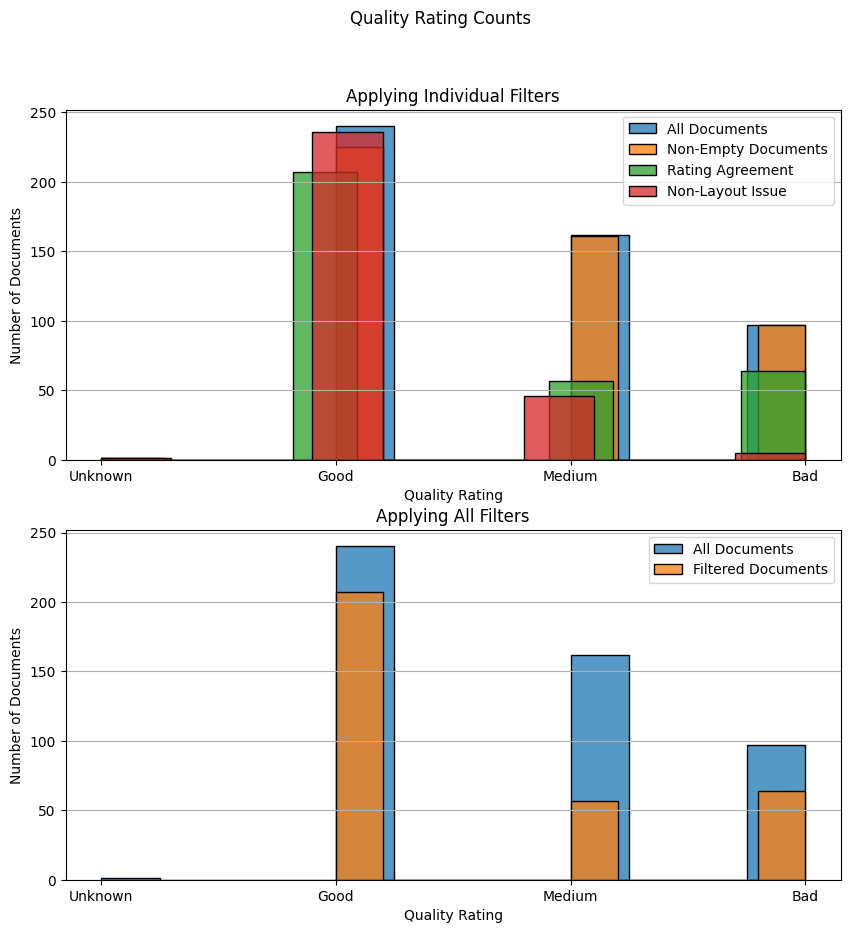

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10), sharex=False, sharey=True)


fig.suptitle("Quality Rating Counts")

sns.color_palette("tab10")

ax1.set_title("Applying Individual Filters")
sns.histplot(judgements.quality, label="All Documents", ax=ax1)
sns.histplot(non_empty.quality, label="Non-Empty Documents", ax=ax1)
sns.histplot(agreement.quality, label="Rating Agreement", ax=ax1)
sns.histplot(non_layout.quality, label="Non-Layout Issue", ax=ax1)

ax2.set_title("Applying All Filters")
sns.histplot(judgements.quality, label="All Documents", ax=ax2)
sns.histplot(filtered.quality, label="Filtered Documents", ax=ax2)

for ax in (ax1, ax2):
    ax.grid(axis="y")
    ax.set_ylabel("Number of Documents")
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(4))
    ax.set_xticklabels(["Unknown", "Good", "Medium", "Bad"])

    ax.legend()



## Plot Features

In [55]:
x_fields = [
    "dict_score",
    "dict_score_gt",
    "n_gram_score",
    "garbage_score",
    # "column_width",
    # "words_per_region",
]

x_fields_normalized = [field + "_normalized" for field in x_fields]

y_field = "quality"


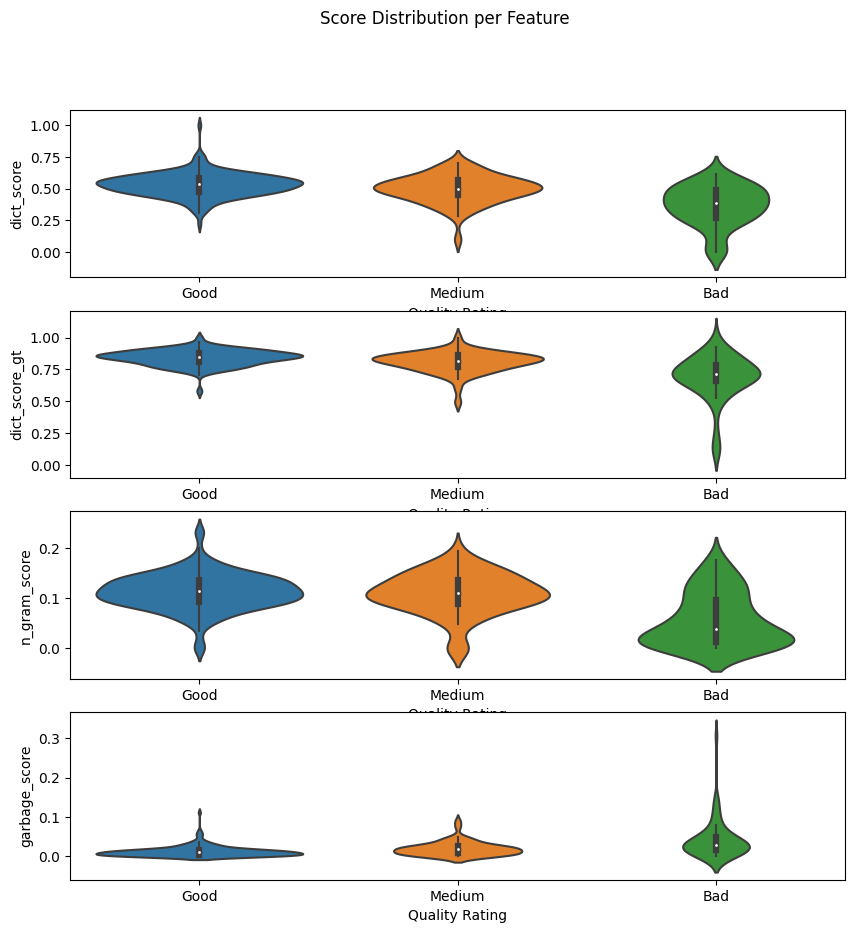

In [56]:
fig, axs = plt.subplots(
    nrows=len(x_fields), figsize=(10, 10), sharex=False, sharey=False
)


fig.suptitle("Score Distribution per Feature")

for ax, column in zip(axs, x_fields):
    sns.violinplot(x=filtered.quality, y=filtered[column], ax=ax)

    ax.set_ylabel(column)
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(3))
    ax.set_xticklabels(["Good", "Medium", "Bad"])



## Classify

### Normalize Features

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(filtered[x_fields].to_numpy())


In [60]:
filtered[x_fields_normalized] = scaler.transform(filtered[x_fields].to_numpy())
filtered

/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/919087271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[x_fields_normalized] = scaler.transform(filtered[x_fields].to_numpy())
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/919087271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[x_fields_normalized] = scaler.transform(filtered[x_fields].to_numpy())
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/919087271.py:1: SettingWithCopyWa

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,dict_score_gt,n_gram_score,garbage_score,column_width,words_per_region,quality,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,0.712289,0.084309,0.002915,47.534884,114.333333,2,-0.919415,-0.842117,-0.368276,-0.585844
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.793615,0.098740,0.005540,44.872340,120.333333,1,-0.526807,-0.123507,-0.054221,-0.488168
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.659038,0.078552,0.003407,53.462687,196.000000,3,-1.419264,-1.312652,-0.493568,-0.567546
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,0.603502,0.067127,0.017182,36.576923,36.375000,2,-1.371546,-1.803379,-0.742209,-0.054925
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,0.740698,0.112956,0.008772,44.869565,68.600000,1,-0.607082,-0.591091,0.255177,-0.367902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,0.863239,0.088985,0.026718,34.555556,52.400000,1,0.847299,0.491704,-0.266518,0.299925
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,0.724370,0.054590,0.025641,25.741935,19.500000,3,-0.071241,-0.735368,-1.015063,0.259863
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,0.935644,0.120795,0.008197,31.304348,122.000000,1,0.590476,1.131490,0.425777,-0.389307
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,0.892186,0.174786,0.000000,35.382353,201.000000,1,0.867893,0.747490,1.600794,-0.694339


In [ ]:
from sklearn import preprocessing

# TODO: refactor for vector operation instead of for loop
# FIXME: remove
for field, normalized_field in zip(x_fields, x_fields_normalized):
    filtered[normalized_field] = preprocessing.minmax_scale(filtered[field])

filtered


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_72796/1452989403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[normalized_field] = preprocessing.minmax_scale(filtered[field])
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_72796/1452989403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[normalized_field] = preprocessing.minmax_scale(filtered[field])
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_72796/1452989403.py:5: SettingWithCopyWarning: 
A v

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,dict_score_gt,n_gram_score,garbage_score,column_width,words_per_region,quality,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,0.719626,0.084818,0.002933,47.534884,114.333333,2,0.441098,0.719626,0.306566,0.002933
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,0.800464,0.103936,0.002915,44.872340,120.333333,1,0.497912,0.800464,0.375665,0.002915
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,0.668775,0.079993,0.001706,53.462687,196.000000,3,0.375340,0.668775,0.289126,0.001706
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,0.618655,0.072263,0.014388,36.576923,36.375000,2,0.382741,0.618655,0.261185,0.014388
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,0.751756,0.114308,0.002959,44.869565,68.600000,1,0.485597,0.751756,0.413152,0.002959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,0.911836,0.136339,0.011696,34.555556,52.400000,1,0.759324,0.911836,0.492783,0.011696
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,0.861111,0.084317,0.000000,25.741935,19.500000,3,0.736154,0.861111,0.304754,0.000000
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,0.935323,0.125418,0.008197,31.304348,122.000000,1,0.667529,0.935323,0.453310,0.008197
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,0.895153,0.174786,0.000000,35.382353,201.000000,1,0.701048,0.895153,0.631745,0.000000


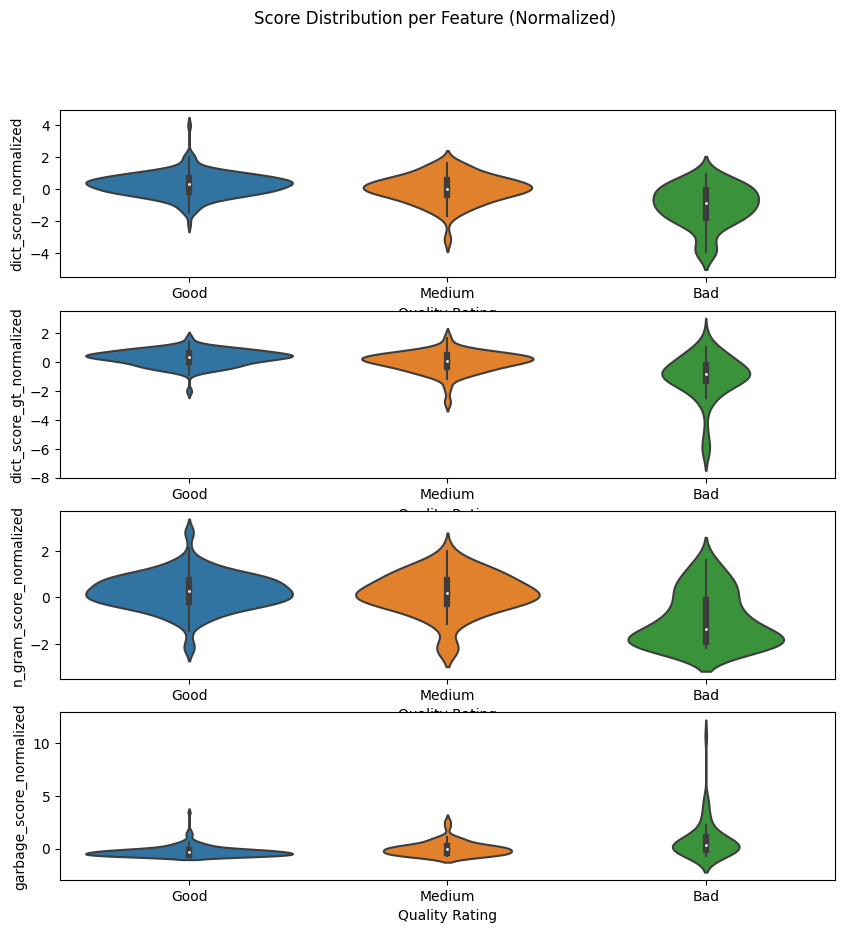

In [61]:
fig, axs = plt.subplots(
    nrows=len(x_fields_normalized), figsize=(10, 10), sharex=False, sharey=False
)

fig.suptitle("Score Distribution per Feature (Normalized)")

for ax, column in zip(axs, x_fields_normalized):
    sns.violinplot(x=filtered.quality, y=filtered[column], ax=ax)

    ax.set_ylabel(column)
    ax.set_xlabel("Quality Rating")
    ax.set_xticks(range(3))
    ax.set_xticklabels(["Good", "Medium", "Bad"])


In [65]:
X = filtered[x_fields_normalized]
y = filtered[y_field]


X


,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
0,-0.919415,-0.842117,-0.368276,-0.585844
1,-0.526807,-0.123507,-0.054221,-0.488168
2,-1.419264,-1.312652,-0.493568,-0.567546
3,-1.371546,-1.803379,-0.742209,-0.054925
5,-0.607082,-0.591091,0.255177,-0.367902
...,...,...,...,...
490,0.847299,0.491704,-0.266518,0.299925
491,-0.071241,-0.735368,-1.015063,0.259863
495,0.590476,1.131490,0.425777,-0.389307
496,0.867893,0.747490,1.600794,-0.694339


### Feature Selection

In [67]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

model = SelectKBest(f_classif, k=3)
model.fit_transform(X, y)

{feature: p for feature, p in zip(X.columns, model.pvalues_)}



{'dict_score_normalized': 5.210712381361755e-21,
 'dict_score_gt_normalized': 6.425184263510816e-23,
 'n_gram_score_normalized': 8.426687355424829e-20,
 'garbage_score_normalized': 1.6048204856147136e-13}

In [68]:
from sklearn.feature_selection import SelectFwe
from sklearn.feature_selection import f_classif

model = SelectFwe(f_classif)
model.fit_transform(X, y)
{feature: p for feature, p in zip(X.columns, model.pvalues_)}


{'dict_score_normalized': 5.210712381361755e-21,
 'dict_score_gt_normalized': 6.425184263510816e-23,
 'n_gram_score_normalized': 8.426687355424829e-20,
 'garbage_score_normalized': 1.6048204856147136e-13}

In [69]:
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import chi2

model = SelectFdr()
model.fit_transform(X, y)
model.pvalues_



array([5.21071238e-21, 6.42518426e-23, 8.42668736e-20, 1.60482049e-13])

### KNN

In [70]:
from sklearn.neighbors import KNeighborsClassifier


n = 5

knn_classifier = KNeighborsClassifier(n_neighbors=n)


In [71]:
from sklearn import model_selection

scores = model_selection.cross_val_score(knn_classifier, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)



0.72 accuracy with a standard deviation of 0.01


In [72]:
column = "prediction_knn"

filtered[column] = model_selection.cross_val_predict(knn_classifier, X, y)


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/1330561670.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(knn_classifier, X, y)


In [73]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}" )

F1 Score for bad quality pages with 'prediction_knn': 0.7143


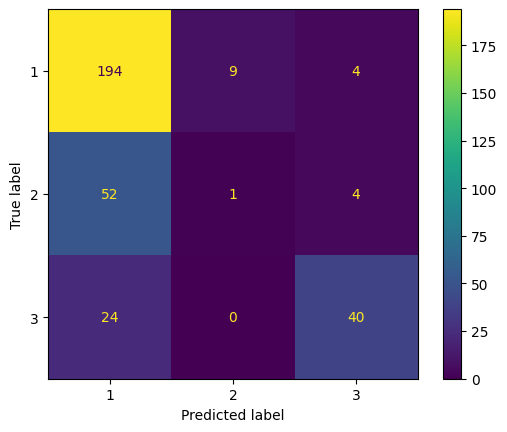

In [74]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(filtered[y_field], filtered[column])


In [75]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3651877133105802

### Decision Tree

In [76]:
from sklearn import tree

max_depth = 3

decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)


In [77]:
from sklearn import model_selection

scores = model_selection.cross_val_score(decision_tree, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)



0.67 accuracy with a standard deviation of 0.04


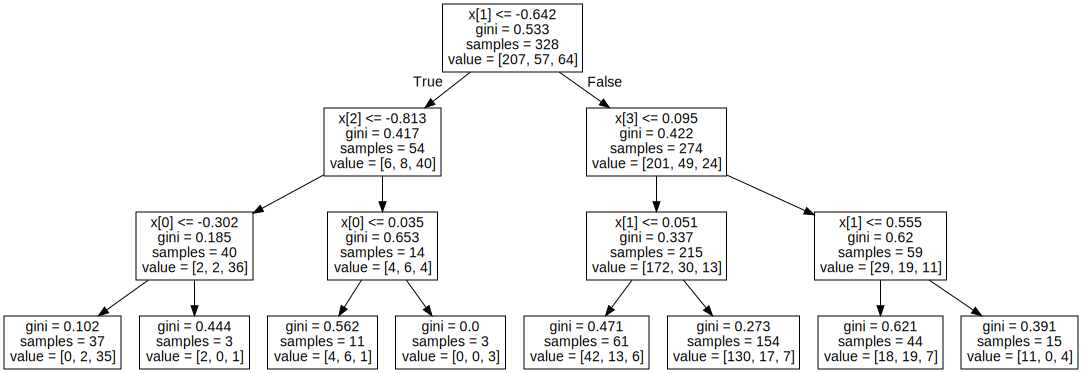

In [78]:
import graphviz
from sklearn.model_selection import train_test_split

decision_tree.fit(X, y)

dot_data = tree.export_graphviz(decision_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph


### Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=max_depth)


In [80]:
from sklearn import model_selection

scores = model_selection.cross_val_score(random_forest, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)



0.73 accuracy with a standard deviation of 0.04


In [81]:
column = "prediction_random_forest"

filtered[column] = model_selection.cross_val_predict(random_forest, X, y)



/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/1220456777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(random_forest, X, y)


In [82]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_random_forest': 0.6607


In [83]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3808958262639973

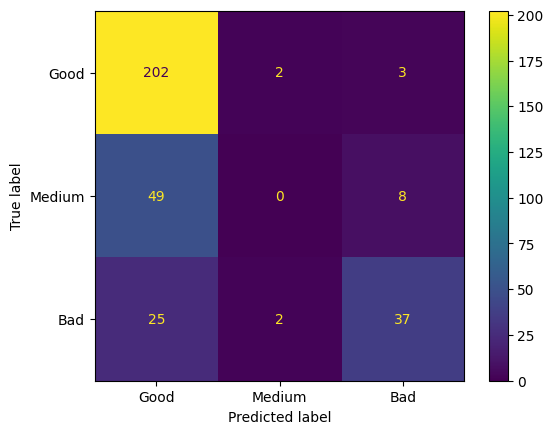

In [84]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


### SVM

In [85]:
from sklearn import svm

svm_classifier = svm.SVC()


In [86]:
from sklearn import model_selection

scores = model_selection.cross_val_score(svm_classifier, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


0.72 accuracy with a standard deviation of 0.03


In [87]:
column = "prediction_svm"

filtered[column] = model_selection.cross_val_predict(svm_classifier, X, y)



/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_87748/1025515477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[column] = model_selection.cross_val_predict(svm_classifier, X, y)


In [88]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_svm': 0.6355


In [89]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3416672120775792

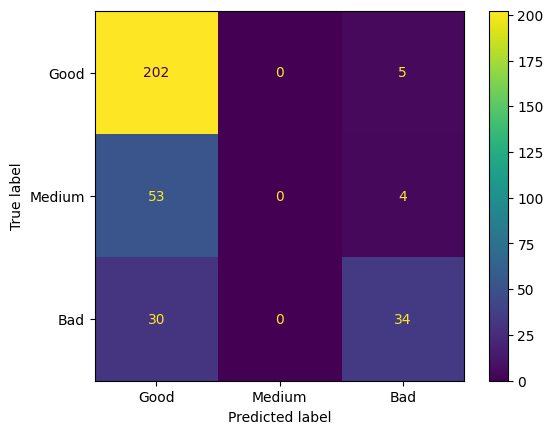

In [90]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


### Multi-layer Perceptron

In [91]:
from sklearn import neural_network

nn = neural_network.MLPClassifier(
    hidden_layer_sizes=(32, 16,), learning_rate="adaptive", max_iter=400
)


In [92]:
scores = model_selection.cross_val_score(nn, X, y)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) 

0.71 accuracy with a standard deviation of 0.02


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [93]:
column = "prediction_nn"

filtered[column] = model_selection.cross_val_predict(nn, X, y)



/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) 

In [94]:
metrics.cohen_kappa_score(filtered[y_field], filtered[column])


0.3939419104366061

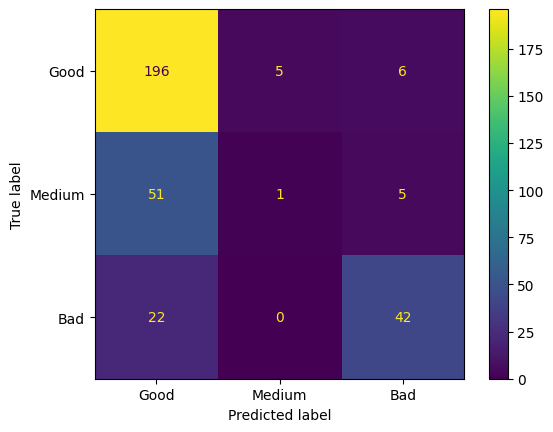

In [95]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(
    filtered[y_field], filtered[column], display_labels=["Good", "Medium", "Bad"]
)


In [96]:
from sklearn import metrics

f1 = metrics.f1_score(filtered[y_field] == 3, filtered[column] == 3)

print(f"F1 Score for bad quality pages with '{column}': {f1:.4}")


F1 Score for bad quality pages with 'prediction_nn': 0.7179


### Analysis

In [97]:
filtered.loc[(filtered.prediction_nn == 1) & (filtered[y_field] == 3)]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,words_per_region,quality,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_knn,prediction_random_forest,prediction_svm,prediction_nn
108,109,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1968_0696,1968,...,1.000000,3,-3.916144,1.700156,-2.203111,-0.694339,1,1,1,1
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,...,20.125000,3,0.696503,0.614068,1.219050,-0.460290,1,1,1,1
171,172,Slecht,Leesvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_2438_1347,2438,...,22.357143,3,0.456544,0.276791,1.561783,-0.454250,1,1,1,1
204,205,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_2778_0747,2778,...,48.400000,3,0.159993,0.689049,-0.527704,1.919860,1,1,1,1
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,...,53.769231,3,-0.496166,0.614947,-0.856906,1.328734,1,1,1,1
272,273,Slecht,NaN,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3580_0688,3580,...,33.583333,3,0.120860,0.139254,-0.667657,0.147181,1,1,1,1
293,294,Slecht,Layout,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_3915_0293,3915,...,38.923077,3,0.289547,-0.390255,0.479064,0.189951,1,1,1,1
307,308,Slecht,"Layout, tekst",3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_4313_0120,4313,...,58.777778,3,0.041844,-0.944836,1.152421,0.010469,1,2,1,1
323,324,Slecht,Layout,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_4448_0474,4448,...,18.727273,3,-0.165580,-0.180490,-0.091657,-0.152389,1,1,1,1
324,325,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_4449_0680,4449,...,17.583333,3,-0.995450,-0.479380,0.309559,-0.694339,1,1,1,1


In [98]:
filtered.loc[(filtered.prediction_nn == 3) & (filtered.quality == 1)][
    ["Filename", "tokens", "text"]
]



,Filename,tokens,text
9,NL-HaNA_1.04.02_1131_0054,"[8, Wij, Confirmeren, met, :, edh=t, ende, is,...",18\nWij Confirmeren met 8: edh=t ende is seeck...
32,NL-HaNA_1.04.02_1302_0976,"[de, posten, raackende, uEE, ende, dit, Compto...",de posten raackende uEE ende dit Comptoir sull...
152,NL-HaNA_1.04.02_2320_1605,"[Van, Mallabaar, onder, dato, 4=e, april, 7346...",Van Mallabaar onder dato 24=e april 17346\nafg...
163,NL-HaNA_1.04.02_2413_0460,"[Van, Ceijlon, onder, dato, 9:', Ianuarij, 737...",Van Ceijlon onder dato 19:' Ianuarij 1737.\nal...
291,NL-HaNA_1.04.02_3884_0332,"[nagezien, Pompeu]",nagezien\nPompeu:
391,NL-HaNA_1.04.02_8980_1908,"[Van, Ceijlon, onderdato, 9:', febr, 741.——, g...","Van Ceijlon, onderdato 19:' febr: 1741.——\ngro..."


In [ ]:
filtered.loc[(filtered.prediction_nn == 1) & (filtered.quality == 3)][
    ["Filename", "tokens", "text"]
]

,Filename,tokens,text
72,NL-HaNA_1.04.02_1672_0566,"[cen, d, o, ordinaire, rantsaeme, omdat, desen...",cen\nd.o\nordinaire rantsaeme 1702 ƒ 10972. 14...
117,NL-HaNA_1.04.02_2036_0307,"[uytslag, van, saken, tot, tyd, en, inslateur,...",uytslag van saken tot tyd en\ninslateur\nS —\n...
171,NL-HaNA_1.04.02_2438_1347,"[Van, Riam, onder, dato, antw, t, eeree, Om, d...",Van Riam onder dato 311\nantw:t\n--\neeree\nOm...
204,NL-HaNA_1.04.02_2778_0747,"[Van, Banda, onder, dato, Jbr, A, j, boekhoude...",Van Banda onder dato 8 Jbr A„j 1751\nboekhoude...
215,NL-HaNA_1.04.02_3010_0357,"[Packen, Per, Transport, met, P, o, d=o, voor,...",164.— „ 2. -. Packen Per Transport met P o/ 15...
221,NL-HaNA_1.04.02_3047_0371,"[De, Debiteuren, en, Eenige, Debet, Lopende, R...",De Debiteuren en Eenige Debet Lopende Reeke„\n...
268,NL-HaNA_1.04.02_3550_0752,"[Een, Hondert, ponden, wijloopen, aan, uwel, E...",Een Hondert ponden —\nwijloopen aan uwel Edele...
272,NL-HaNA_1.04.02_3580_0688,"[Nagezie, e, ere, i, J, r, V, r, Ole, Lasten, ...",Nagezie\ne ere\ni\nJ„r V„r Ole\nLasten in dit ...
293,NL-HaNA_1.04.02_3915_0293,"[boven, hunne, waarde, zijn, uijtgegeeven, van...",boven hunne waarde zijn uijtgegeeven van uwelE...
295,NL-HaNA_1.04.02_3985_0170,"[Padang, op, Sumatra, s, West, Cust, Aij, ulti...",16/\nPadang op Sumatra's West Cust Aij ultimo ...


In [99]:
filtered.loc[filtered.prediction_nn != filtered.prediction_knn][
    [y_field]
    + ["prediction_nn", "prediction_knn", "text", "tokens", "Filename"]
    + x_fields_normalized
]



,quality,prediction_nn,prediction_knn,text,tokens,Filename,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
9,1,3,2,18\nWij Confirmeren met 8: edh=t ende is seeck...,"[8, Wij, Confirmeren, met, :, edh=t, ende, is,...",NL-HaNA_1.04.02_1131_0054,-0.830042,-0.615087,-0.890413,-0.588917
92,1,2,1,1004,[004],NL-HaNA_1.04.02_1851_0827,3.999831,1.700156,-2.203111,-0.694339
152,1,3,2,Van Mallabaar onder dato 24=e april 17346\nafg...,"[Van, Mallabaar, onder, dato, 4=e, april, 7346...",NL-HaNA_1.04.02_2320_1605,-0.530758,-0.475254,-0.728200,0.597810
252,1,1,2,280\nop heeden den 23 Maart 1711. Compareerde ...,"[80, op, heeden, den, 3, Maart, 711., Comparee...",NL-HaNA_1.04.02_3330_0390,-0.081526,0.280920,0.135506,0.098980
303,1,1,2,"p„s,\n. Co\nSententie van\nJacobus de Bruy","[p„s, , Co, Sententie, van, Jacobus, de, Bruy]",NL-HaNA_1.04.02_4071_1018,2.152771,0.521996,0.370388,-0.694339
354,1,1,2,van Timor den 2=' Septemb=r A=o 1703. —\ncogel...,"[van, Timor, den, =', Septemb=r, A=o, 703., , ...",NL-HaNA_1.04.02_8314_0347,-0.151717,0.478287,0.425813,0.515869
419,2,2,1,Copia\nRegister der stucken\nprofiso rat: off:...,"[Copia, Register, der, stucken, profiso, rat, ...",NL-HaNA_1.04.02_9358_0188,-0.851895,-0.960206,0.136434,0.997201
427,2,1,2,ve e e\n„ 13. —\nC. — Den onderhandse verklari...,"[ve, e, e, , 3., , C, , Den, onderhandse, verk...",NL-HaNA_1.04.02_9424_0784,-0.613619,-0.241557,1.456521,0.765029
471,3,3,1,18. 15\nHudolff Sigfhied Aleman Cap=n\nwilitai...,"[8., 5, Hudolff, Sigfhied, Aleman, Cap=n, wili...",NL-HaNA_1.04.02_10557_0203,0.143766,-0.660589,-0.387255,0.712909
481,2,3,1,Equipagiemeester na boord van hetselven\nte be...,"[Equipagiemeester, na, boord, van, hetselven, ...",NL-HaNA_1.04.02_10712_0537,0.027691,-1.164500,-0.517918,-0.457308


In [100]:
error_type_columns = ["error_type_" + str(i) for i in range(1, 6)]
prediction_columns = [
    column for column in filtered.columns if column.startswith("prediction")
]

filtered.loc[
    filtered[error_type_columns].notna().all(axis="columns")
    & (filtered.quality != filtered.prediction_nn)
][error_type_columns + prediction_columns + ["quality"]]



,error_type_1,error_type_2,error_type_3,error_type_4,error_type_5,prediction_knn,prediction_random_forest,prediction_svm,prediction_nn,quality
170,13.0,0.0,1.0,2.0,0.0,3,3,3,3,2
220,1.0,1.0,2.0,3.0,0.0,1,1,1,1,2
281,5.0,2.0,3.0,4.0,0.0,1,1,1,1,2
294,1.0,1.0,1.0,1.0,0.0,1,1,1,1,2


# Test on HTR data

In [101]:
classifier = nn.fit(X, y)

/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [102]:
classifier.feature_names_in_

array(['dict_score_normalized', 'dict_score_gt_normalized',
       'n_gram_score_normalized', 'garbage_score_normalized'],
      dtype=object)

In [104]:
from joblib import dump

CLASSIFIER_FILE = DATA_DIR / "htr_text_classifier_nn.joblib"
if CLASSIFIER_FILE.exists():
    raise FileExistsError(CLASSIFIER_FILE)
dump(classifier, CLASSIFIER_FILE)


['/Users/carstenschnober/LAHTeR/workspace/nautilusocr/data/htr_text_classifier_nn.joblib']

In [111]:
RESULTS_FILE = DATA_DIR / "allresults.tar.bz2"
assert RESULTS_FILE.is_file()

ENCODING = "UTF-8"
TOTAL_FILES = 6873
LINES_PER_FILE = 10000

### Random Lines

In [122]:
import tarfile
import random


OUTPUT_LINES = 10000

total_lines = TOTAL_FILES * LINES_PER_FILE

# line_numbers = set(random.choices(range(total_lines), k=OUTPUT_LINES))
# file_numbers = {int(line / LINES_PER_FILE) for line in line_numbers}

random_threshold = 1 - (OUTPUT_LINES / total_lines)

random_threshold


0.9998545031281827

In [123]:
from tqdm import tqdm

lines = []

with tqdm(total=OUTPUT_LINES, unit="line", desc="Reading") as pbar, tarfile.open(
    RESULTS_FILE, "r:bz2"
) as tar:
    for tarinfo in tar:
        if len(lines) >= OUTPUT_LINES:
            break
        for line in tar.extractfile(tarinfo):
            if len(lines) >= OUTPUT_LINES:
                break
            if random.random() > random_threshold:
                lines.append(line.decode(ENCODING))
                pbar.update()


lines


Reading: 100%|██████████| 10000/10000 [04:14<00:00, 39.30line/s]


['/data/globalise/1.04.02/10000/imagesnippets/NL-HaNA_1.04.02_10000_0096/NL-HaNA_1.04.02_10000_0096.xml-line_26616954-9582-44bd-867f-a020823bba19.png\t0.90011436\tden 22. November beslooten hebben op de\n',
 '/data/globalise/1.04.02/10000/imagesnippets/NL-HaNA_1.04.02_10000_0041/NL-HaNA_1.04.02_10000_0041.xml-line_3986d3df-1336-4799-af28-0a84283c01fb.png\t0.8632898\tgens het voorstel van meer„\n',
 '/data/globalise/1.04.02/10000/imagesnippets/NL-HaNA_1.04.02_10000_0107/NL-HaNA_1.04.02_10000_0107.xml-line_8fd3e013-04ab-499e-8e30-ed74e4e7ff57.png\t0.056162216\t„§89. Behalven de gewoone verpligting zijn bij de\n',
 '/data/globalise/1.04.02/10000/imagesnippets/NL-HaNA_1.04.02_10000_0136/NL-HaNA_1.04.02_10000_0136.xml-line_02726e16-5ea6-4d1d-a8e9-cf225728c23b.png\t0.6001499\tvan de plaets, niet te konnen worden\n',
 '/data/globalise/1.04.02/10000/imagesnippets/NL-HaNA_1.04.02_10000_0175/NL-HaNA_1.04.02_10000_0175.xml-line_4de8456d-8755-4f5c-964a-afcfb36a082b.png\t0.31265947\tdienaaren gegee

In [218]:
import os
from io import StringIO

results = (
    pd.read_csv(
        StringIO(os.linesep.join(lines)),
        delimiter="\t",
        header=None,
        names=["File", "Score", "text"],
        dtype={"text": str},
    )
    .dropna(subset="text")
    .reset_index()
)
results


,index,File,Score,text
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.900114,den 22. November beslooten hebben op de
1,1,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.863290,gens het voorstel van meer„
2,2,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.056162,„§89. Behalven de gewoone verpligting zijn bij de
3,3,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.600150,"van de plaets, niet te konnen worden"
4,4,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.312659,"dienaaren gegeeven, en wijl het onder„"
...,...,...,...,...
9930,9995,/data/globalise/1.04.02/2215/imagesnippets/NL-...,0.766841,Alblasserdam.
9931,9996,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.054855,dihoelatta..
9932,9997,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.912021,een quade naem te doen Erlangen
9933,9998,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.098968,5 9 2„


In [219]:
results["tokens"] = results.text.apply(get_tokens)
results

,index,File,Score,text,tokens
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.900114,den 22. November beslooten hebben op de,"[den, November, beslooten, hebben, op, de]"
1,1,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.863290,gens het voorstel van meer„,"[gens, het, voorstel, van, meer]"
2,2,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.056162,„§89. Behalven de gewoone verpligting zijn bij de,"[Behalven, de, gewoone, verpligting, zijn, bij..."
3,3,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.600150,"van de plaets, niet te konnen worden","[van, de, plaets, niet, te, konnen, worden]"
4,4,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.312659,"dienaaren gegeeven, en wijl het onder„","[dienaaren, gegeeven, en, wijl, het, onder]"
...,...,...,...,...,...
9930,9995,/data/globalise/1.04.02/2215/imagesnippets/NL-...,0.766841,Alblasserdam.,[Alblasserdam]
9931,9996,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.054855,dihoelatta..,[dihoelatta]
9932,9997,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.912021,een quade naem te doen Erlangen,"[een, quade, naem, te, doen, Erlangen]"
9933,9998,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.098968,5 9 2„,[]


In [221]:
results["dict_score"] = results.tokens.apply(get_dict_score)
results.iloc[results.dict_score.sort_values().index]


,index,File,Score,text,tokens,dict_score
5563,5600,/data/globalise/1.04.02/1491/imagesnippets/NL-...,0.723684,eene,[eene],0.0
7801,7850,/data/globalise/1.04.02/1816/imagesnippets/NL-...,0.056061,-,[],0.0
5766,5803,/data/globalise/1.04.02/1511/imagesnippets/NL-...,0.742800,.,[],0.0
7804,7853,/data/globalise/1.04.02/1817/imagesnippets/NL-...,0.975127,malacca geschreeven,"[malacca, geschreeven]",0.0
5763,5800,/data/globalise/1.04.02/1511/imagesnippets/NL-...,0.019276,. . . . . . . . . . . . . . . . . . . . . . . ...,[],0.0
...,...,...,...,...,...,...
8900,8955,/data/globalise/1.04.02/2029/imagesnippets/NL-...,0.287080,mogen scheppen.,"[mogen, scheppen]",1.0
6990,7033,/data/globalise/1.04.02/1657/imagesnippets/NL-...,0.767242,een monster toe te,"[een, monster, toe, te]",1.0
8898,8953,/data/globalise/1.04.02/2028/imagesnippets/NL-...,0.557367,"ging in persoon inde venster leggen,","[ging, in, persoon, inde, venster, leggen]",1.0
6966,7009,/data/globalise/1.04.02/1653/imagesnippets/NL-...,0.975560,werden,[werden],1.0


In [222]:
results["dict_score_gt"] = results.tokens.apply(get_dict_score_gt)
results.iloc[results.dict_score_gt.sort_values().index]


,index,File,Score,text,tokens,dict_score,dict_score_gt
3471,3495,/data/globalise/1.04.02/1271/imagesnippets/NL-...,0.012532,png=r,[png=r],0.000000,0.0
8217,8269,/data/globalise/1.04.02/1896/imagesnippets/NL-...,0.000045,. . . . . . . „. „ 3: 12 „ 5„ „ „ 1: 4 3: 312 ...,[],0.000000,0.0
4200,4231,/data/globalise/1.04.02/1366/imagesnippets/NL-...,0.085024,1,[],0.000000,0.0
4209,4240,/data/globalise/1.04.02/1366/imagesnippets/NL-...,0.003871,9de 98e,[],0.000000,0.0
1250,1257,/data/globalise/1.04.02/10548/imagesnippets/NL...,0.523454,7,[],0.000000,0.0
...,...,...,...,...,...,...,...
4780,4815,/data/globalise/1.04.02/1429/imagesnippets/NL-...,0.907108,dato 27=en maart,"[dato, =en, maart]",0.750000,1.0
4779,4814,/data/globalise/1.04.02/1429/imagesnippets/NL-...,0.062378,„t,[t],1.000000,1.0
4776,4811,/data/globalise/1.04.02/1429/imagesnippets/NL-...,0.177872,gebouw van pakhuijsen 'tgeen zij ook maar sood...,"[gebouw, van, pakhuijsen, tgeen, zij, ook, maa...",0.520833,1.0
4792,4827,/data/globalise/1.04.02/1431/imagesnippets/NL-...,0.110621,"Te werden de fluijt walenburg, beladen met","[Te, werden, de, fluijt, walenburg, beladen, met]",0.571429,1.0


In [223]:

results["n_gram_score"] = results.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
results.iloc[results.n_gram_score.sort_values().index]


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score
4967,5002,/data/globalise/1.04.02/1444/imagesnippets/NL-...,0.225933,uw hoog Edelhedens wijsen goetduncken,"[uw, hoog, Edelhedens, wijsen, goetduncken]",0.181818,1.000000,0.0
5717,5754,/data/globalise/1.04.02/1508/imagesnippets/NL-...,0.018170,daer deselve voor uijtgetekent sijn,"[daer, deselve, voor, uijtgetekent, sijn]",0.129032,0.612903,0.0
5712,5749,/data/globalise/1.04.02/1507/imagesnippets/NL-...,0.222473,"door 't goede weer, en wind, om—","[door, t, goede, weer, en, wind, om]",1.000000,1.000000,0.0
5711,5748,/data/globalise/1.04.02/1507/imagesnippets/NL-...,0.193890,gedierdens,[gedierdens],0.000000,0.000000,0.0
5710,5747,/data/globalise/1.04.02/1507/imagesnippets/NL-...,0.004277,1600„ _: sandelhout. . . . . . „ 196. 14. 8,[sandelhout],1.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...
2784,2803,/data/globalise/1.04.02/1156/imagesnippets/NL-...,0.949994,den,[den],1.000000,1.000000,1.0
9294,9353,/data/globalise/1.04.02/2100/imagesnippets/NL-...,0.754117,den,[den],1.000000,1.000000,1.0
3102,3123,/data/globalise/1.04.02/1221/imagesnippets/NL-...,0.176839,den 693269,[den],1.000000,1.000000,1.0
7254,7298,/data/globalise/1.04.02/1712/imagesnippets/NL-...,0.010285,den. . . . . ƒ 102. -. -.,[den],1.000000,1.000000,1.0


In [224]:
results["garbage_score"] = results.tokens.apply(get_garbage_score)
results.iloc[results.garbage_score.sort_values().index]


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.900114,den 22. November beslooten hebben op de,"[den, November, beslooten, hebben, op, de]",0.433333,1.000000,0.166667,0.0
6596,6637,/data/globalise/1.04.02/1596/imagesnippets/NL-...,0.272905,deselve hoe veel peper aldaar voor d' EComp: p...,"[deselve, hoe, veel, peper, aldaar, voor, d, E...",0.637931,0.844828,0.114923,0.0
6597,6638,/data/globalise/1.04.02/1596/imagesnippets/NL-...,0.150856,gevallen ons vervolgens te doene Eijsschen daa...,"[gevallen, ons, vervolgens, te, doene, Eijssch...",0.587302,0.904762,0.000000,0.0
6598,6639,/data/globalise/1.04.02/1596/imagesnippets/NL-...,0.153404,kort met een gelijk getal staat,"[kort, met, een, gelijk, getal, staat]",1.000000,1.000000,0.135833,0.0
6599,6640,/data/globalise/1.04.02/1596/imagesnippets/NL-...,0.058177,genoegssame quantiteijt zullen uijtleveren om ...,"[genoegssame, quantiteijt, zullen, uijtleveren...",0.346667,0.853333,0.062692,0.0
...,...,...,...,...,...,...,...,...,...
1747,1758,/data/globalise/1.04.02/1084/imagesnippets/NL-...,0.000006,1F. REfNEE.,[REfNEE],0.000000,0.000000,0.000000,1.0
1471,1479,/data/globalise/1.04.02/10672/imagesnippets/NL...,0.000735,wanClrcy.,[wanClrcy],0.000000,0.000000,0.000000,1.0
6285,6326,/data/globalise/1.04.02/1560/imagesnippets/NL-...,0.661636,uEd:,[uEd],0.000000,1.000000,0.000000,1.0
6092,6131,/data/globalise/1.04.02/1541/imagesnippets/NL-...,0.106135,mmmman,[mmmman],0.000000,0.000000,0.000000,1.0


In [226]:
results[x_fields_normalized] = scaler.transform(results[x_fields].to_numpy())
results

/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.900114,den 22. November beslooten hebben op de,"[den, November, beslooten, hebben, op, de]",0.433333,1.000000,0.166667,0.0,-1.271911,1.419057,-1.476891,-0.17109
1,1,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.863290,gens het voorstel van meer„,"[gens, het, voorstel, van, meer]",0.818182,1.000000,0.383000,0.0,1.570710,1.419057,-0.131413,-0.17109
2,2,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.056162,„§89. Behalven de gewoone verpligting zijn bij de,"[Behalven, de, gewoone, verpligting, zijn, bij...",0.297297,1.000000,0.000000,0.0,-2.276719,1.419057,-2.513469,-0.17109
3,3,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.600150,"van de plaets, niet te konnen worden","[van, de, plaets, niet, te, konnen, worden]",0.586207,1.000000,0.135143,0.0,-0.142735,1.419057,-1.672952,-0.17109
4,4,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.312659,"dienaaren gegeeven, en wijl het onder„","[dienaaren, gegeeven, en, wijl, het, onder]",0.451613,1.000000,0.161500,0.0,-1.136892,1.419057,-1.509025,-0.17109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,9995,/data/globalise/1.04.02/2215/imagesnippets/NL-...,0.766841,Alblasserdam.,[Alblasserdam],1.000000,0.000000,0.000000,0.0,2.913680,-6.152626,-2.513469,-0.17109
9931,9996,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.054855,dihoelatta..,[dihoelatta],0.000000,0.000000,0.000000,0.0,-4.472657,-6.152626,-2.513469,-0.17109
9932,9997,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.912021,een quade naem te doen Erlangen,"[een, quade, naem, te, doen, Erlangen]",0.346154,1.000000,0.135833,0.0,-1.915848,1.419057,-1.668658,-0.17109
9933,9998,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.098968,5 9 2„,[],0.000000,0.000000,0.000000,0.0,-4.472657,-6.152626,-2.513469,-0.17109


In [ ]:
# from sklearn import preprocessing


# # TODO: refactor for vector operation instead of for loop
# for field, normalized_field in zip(x_fields, x_fields_normalized):
#     results[normalized_field] = preprocessing.minmax_scale(results[field])

# results


,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn,Predicted Quality
0,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.274346,"ter hand steleten, met verzoek om","[ter, hand, steleten, met, verzoek, om]",1.000000,0.703704,0.160167,0.000000,1.000000,0.703704,0.160167,0.000000,1,Good
1,/data/globalise/1.04.02/10002/imagesnippets/NL...,0.099576,mij ni verzeekert te kunnen houden van de de,"[mij, ni, verzeekert, te, kunnen, houden, van,...",0.666667,0.666667,0.105111,0.000000,0.666667,0.666667,0.105111,0.000000,1,Good
2,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.180390,"voldaan, ter schadeloos stelling van de„","[voldaan, ter, schadeloos, stelling, van, de]",1.000000,1.000000,0.317833,0.000000,1.000000,1.000000,0.317833,0.000000,1,Good
3,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.222291,„ve papieren in een apparte bande,"[ve, papieren, in, een, apparte, bande]",0.666667,0.814815,0.135833,0.000000,0.666667,0.814815,0.135833,0.000000,1,Good
4,/data/globalise/1.04.02/10003/imagesnippets/NL...,0.012169,hebben overgebragt. . . . . . . . . . . . . . ...,"[hebben, overgebragt, , , , , , , , , , , , , ...",0.272727,1.000000,0.000000,0.083333,0.272727,1.000000,0.000000,0.083333,3,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.831892,te dragen,"[te, dragen]",1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,Good
9996,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.024515,Sondag 25: wist 'sE: Comp:s hoffgaager te verh...,"[Sondag, 5:, wist, sE:, Comp:s, hoffgaager, te...",0.522727,0.772727,0.097000,0.111111,0.522727,0.772727,0.097000,0.111111,3,Bad
9997,/data/globalise/1.04.02/2241/imagesnippets/NL-...,0.083118,Van Bengale onderdato 3:' maart 1732,"[Van, Bengale, onderdato, :', maart, 732]",0.379310,1.000000,0.000000,0.000000,0.379310,1.000000,0.000000,0.000000,1,Good
9998,/data/globalise/1.04.02/2242/imagesnippets/NL-...,0.596369,van sijnen raad —.,"[van, sijnen, raad, .]",0.500000,1.000000,0.236500,0.000000,0.500000,1.000000,0.236500,0.000000,1,Good


In [227]:
results["prediction_nn"] = classifier.predict(results[x_fields_normalized])
results

,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.900114,den 22. November beslooten hebben op de,"[den, November, beslooten, hebben, op, de]",0.433333,1.000000,0.166667,0.0,-1.271911,1.419057,-1.476891,-0.17109,1
1,1,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.863290,gens het voorstel van meer„,"[gens, het, voorstel, van, meer]",0.818182,1.000000,0.383000,0.0,1.570710,1.419057,-0.131413,-0.17109,1
2,2,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.056162,„§89. Behalven de gewoone verpligting zijn bij de,"[Behalven, de, gewoone, verpligting, zijn, bij...",0.297297,1.000000,0.000000,0.0,-2.276719,1.419057,-2.513469,-0.17109,1
3,3,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.600150,"van de plaets, niet te konnen worden","[van, de, plaets, niet, te, konnen, worden]",0.586207,1.000000,0.135143,0.0,-0.142735,1.419057,-1.672952,-0.17109,1
4,4,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.312659,"dienaaren gegeeven, en wijl het onder„","[dienaaren, gegeeven, en, wijl, het, onder]",0.451613,1.000000,0.161500,0.0,-1.136892,1.419057,-1.509025,-0.17109,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,9995,/data/globalise/1.04.02/2215/imagesnippets/NL-...,0.766841,Alblasserdam.,[Alblasserdam],1.000000,0.000000,0.000000,0.0,2.913680,-6.152626,-2.513469,-0.17109,1
9931,9996,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.054855,dihoelatta..,[dihoelatta],0.000000,0.000000,0.000000,0.0,-4.472657,-6.152626,-2.513469,-0.17109,3
9932,9997,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.912021,een quade naem te doen Erlangen,"[een, quade, naem, te, doen, Erlangen]",0.346154,1.000000,0.135833,0.0,-1.915848,1.419057,-1.668658,-0.17109,1
9933,9998,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.098968,5 9 2„,[],0.000000,0.000000,0.000000,0.0,-4.472657,-6.152626,-2.513469,-0.17109,3


[Text(0, 0, 'Good'), Text(1, 0, 'Medium'), Text(2, 0, 'Bad')]

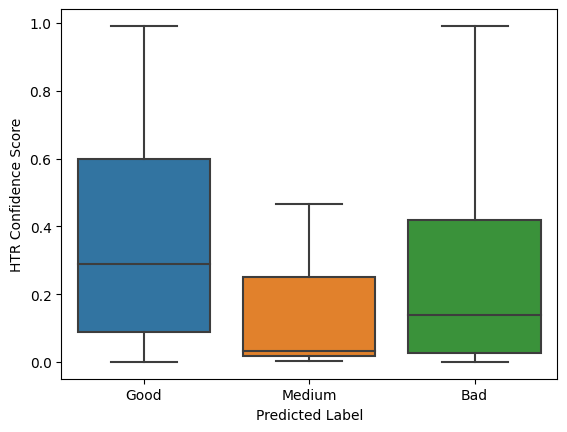

In [230]:
ax = sns.boxplot(x=results["prediction_nn"], y=results["Score"])
ax.set_xlabel("Predicted Label")
ax.set_ylabel("HTR Confidence Score")
ax.set_xticklabels(["Good", "Medium", "Bad"])



In [231]:
mapper = {1: "Good", 2: "Medium", 3: "Bad"}
results["Predicted Quality"] = results.prediction_nn.apply(lambda x: mapper[x])
results


,index,File,Score,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn,Predicted Quality
0,0,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.900114,den 22. November beslooten hebben op de,"[den, November, beslooten, hebben, op, de]",0.433333,1.000000,0.166667,0.0,-1.271911,1.419057,-1.476891,-0.17109,1,Good
1,1,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.863290,gens het voorstel van meer„,"[gens, het, voorstel, van, meer]",0.818182,1.000000,0.383000,0.0,1.570710,1.419057,-0.131413,-0.17109,1,Good
2,2,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.056162,„§89. Behalven de gewoone verpligting zijn bij de,"[Behalven, de, gewoone, verpligting, zijn, bij...",0.297297,1.000000,0.000000,0.0,-2.276719,1.419057,-2.513469,-0.17109,1,Good
3,3,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.600150,"van de plaets, niet te konnen worden","[van, de, plaets, niet, te, konnen, worden]",0.586207,1.000000,0.135143,0.0,-0.142735,1.419057,-1.672952,-0.17109,1,Good
4,4,/data/globalise/1.04.02/10000/imagesnippets/NL...,0.312659,"dienaaren gegeeven, en wijl het onder„","[dienaaren, gegeeven, en, wijl, het, onder]",0.451613,1.000000,0.161500,0.0,-1.136892,1.419057,-1.509025,-0.17109,1,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9930,9995,/data/globalise/1.04.02/2215/imagesnippets/NL-...,0.766841,Alblasserdam.,[Alblasserdam],1.000000,0.000000,0.000000,0.0,2.913680,-6.152626,-2.513469,-0.17109,1,Good
9931,9996,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.054855,dihoelatta..,[dihoelatta],0.000000,0.000000,0.000000,0.0,-4.472657,-6.152626,-2.513469,-0.17109,3,Bad
9932,9997,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.912021,een quade naem te doen Erlangen,"[een, quade, naem, te, doen, Erlangen]",0.346154,1.000000,0.135833,0.0,-1.915848,1.419057,-1.668658,-0.17109,1,Good
9933,9998,/data/globalise/1.04.02/2216/imagesnippets/NL-...,0.098968,5 9 2„,[],0.000000,0.000000,0.000000,0.0,-4.472657,-6.152626,-2.513469,-0.17109,3,Bad


In [240]:
OUTPUT_FILE = DATA_DIR / "results_classification_rescale.csv"

output_columns = ["File", "Score", "text", "Predicted Quality"]

if OUTPUT_FILE.exists():
    raise FileExistsError(OUTPUT_FILE)

results[output_columns].to_csv(OUTPUT_FILE)


### Random Pages

In [112]:
OUTPUT_PAGES = 1000
TOTAL_PAGES = 4726734 - 6873

random_threshold = 1 - (OUTPUT_PAGES / TOTAL_PAGES)

random_threshold


0.9997881293538093

In [119]:
import random
import tarfile

current_page = None
select = False
lines = []

with tqdm(
    total=OUTPUT_PAGES, unit="page", desc="Selecting Pages"
) as pbar, tarfile.open(RESULTS_FILE, "r:bz2") as tar:
    for tarinfo in tqdm(tar, total=TOTAL_FILES, unit="file", desc="Reading Tar file"):
        if pbar.n >= OUTPUT_PAGES:
            break
        for line in tar.extractfile(tarinfo):
            if pbar.n >= OUTPUT_PAGES:
                break
            try:
                decoded = line.decode(ENCODING)

                path = Path(decoded.split("\t")[0])
                filename = path.parent.name

                if filename != current_page:
                    logging.debug(f"New page: '{filename}'")
                    current_page = filename
                    select = random.random() >= random_threshold
                    if select:
                        logging.info(f"Page selected: '{filename}'")
                        pbar.update()
                if select:
                    lines.append(decoded)

            except Exception as e:
                logging.error(
                    f"Failed to parse file '{tarinfo.name}', skipping: {str(e)}"
                )

len(lines)


Selecting Pages: 100%|██████████| 1000/1000 [25:44<00:00,  1.54s/page]


['/data/globalise/1.04.02/10005/imagesnippets/NL-HaNA_1.04.02_10005_0133/NL-HaNA_1.04.02_10005_0133.xml-de21451d-16be-4152-856f-58417a8fb66d.png\t0.17648126\t10:–\n',
 '/data/globalise/1.04.02/10005/imagesnippets/NL-HaNA_1.04.02_10005_0133/NL-HaNA_1.04.02_10005_0133.xml-line_582313d9-c62e-4c37-8b8c-83582528eb7c.png\t0.28252128\t7\n',
 "/data/globalise/1.04.02/10005/imagesnippets/NL-HaNA_1.04.02_10005_0133/NL-HaNA_1.04.02_10005_0133.xml-line_7314c8d5-1742-4943-b672-125fea02d060.png\t0.10125859\tvan de verpagte Domainen van 't Gouvernem\n",
 '/data/globalise/1.04.02/10005/imagesnippets/NL-HaNA_1.04.02_10005_0133/NL-HaNA_1.04.02_10005_0133.xml-line_8d705511-c770-401c-98ef-0eb4259d18a8.png\t0.47781733\tCeilon\n',
 '/data/globalise/1.04.02/10005/imagesnippets/NL-HaNA_1.04.02_10005_0133/NL-HaNA_1.04.02_10005_0133.xml-line_4caa46c4-b868-4161-bdc5-a84049f9cf06.png\t0.20999983\tNagezie\n',
 '/data/globalise/1.04.02/10005/imagesnippets/NL-HaNA_1.04.02_10005_0133/NL-HaNA_1.04.02_10005_0133.xml-cb

In [124]:
from io import StringIO

results_pages = pd.read_csv(
    StringIO(os.linesep.join(lines)),
    delimiter="\t",
    header=None,
    names=["File", "Score", "text"],
    dtype={"text": str}
).dropna(subset="text")
results_pages


,File,Score,text
0,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.176481,10:–
1,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.282521,7
2,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.101259,van de verpagte Domainen van 't Gouvernem
3,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.477817,Ceilon
4,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.210000,Nagezie
...,...,...,...
37489,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.013639,9
37490,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.913769,2100:
37491,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.947912,heeft
37492,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.586446,2109:


In [125]:
results_pages["page"] = results_pages.File.apply(lambda x: Path(x).parent.name)
results_pages

,File,Score,text,page
0,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.176481,10:–,NL-HaNA_1.04.02_10005_0133
1,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.282521,7,NL-HaNA_1.04.02_10005_0133
2,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.101259,van de verpagte Domainen van 't Gouvernem,NL-HaNA_1.04.02_10005_0133
3,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.477817,Ceilon,NL-HaNA_1.04.02_10005_0133
4,/data/globalise/1.04.02/10005/imagesnippets/NL...,0.210000,Nagezie,NL-HaNA_1.04.02_10005_0133
...,...,...,...,...
37489,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.013639,9,NL-HaNA_1.04.02_9509_0902
37490,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.913769,2100:,NL-HaNA_1.04.02_9509_0902
37491,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.947912,heeft,NL-HaNA_1.04.02_9509_0902
37492,/data/globalise/1.04.02/9509/imagesnippets/NL-...,0.586446,2109:,NL-HaNA_1.04.02_9509_0902


In [126]:
merged_pages = results_pages[["page", "text"]].groupby("page").agg({"text": os.linesep.join}).reset_index()
merged_pages


,page,text
0,NL-HaNA_1.04.02_10005_0133,10:–\n7\nvan de verpagte Domainen van 't Gouve...
1,NL-HaNA_1.04.02_10011_0406,deselfde remarque gemaakt\nde afkorting van de...
2,NL-HaNA_1.04.02_10029_0132,bank\nals niet excedeerende de bepaalde 10. p:...
3,NL-HaNA_1.04.02_10035_0571,wij d' Eene hadde van die door het\nbehouden v...
4,NL-HaNA_1.04.02_10061_0160,"zijn Edele egter hadde bespiurt, dat alles\nco..."
...,...,...
995,NL-HaNA_1.04.02_9491_0256,Accordeert\nWm Heegel\ndoor ons : W: afgeteken...
996,NL-HaNA_1.04.02_9505_0132,onger\n„dewelke na sulx in 't water gespengen ...
997,NL-HaNA_1.04.02_9505_0405,er Nog hebben wij commissarissen goed gevonden...
998,NL-HaNA_1.04.02_9509_0834,gebonden op zijn prauw genomen had


In [127]:
merged_pages["tokens"] = merged_pages.text.apply(get_tokens)
merged_pages

,page,text,tokens
0,NL-HaNA_1.04.02_10005_0133,10:–\n7\nvan de verpagte Domainen van 't Gouve...,"[0:–, , van, de, verpagte, Domainen, van, t, G..."
1,NL-HaNA_1.04.02_10011_0406,deselfde remarque gemaakt\nde afkorting van de...,"[deselfde, remarque, gemaakt, de, afkorting, v..."
2,NL-HaNA_1.04.02_10029_0132,bank\nals niet excedeerende de bepaalde 10. p:...,"[bank, als, niet, excedeerende, de, bepaalde, ..."
3,NL-HaNA_1.04.02_10035_0571,wij d' Eene hadde van die door het\nbehouden v...,"[wij, d, Eene, hadde, van, die, door, het, beh..."
4,NL-HaNA_1.04.02_10061_0160,"zijn Edele egter hadde bespiurt, dat alles\nco...","[zijn, Edele, egter, hadde, bespiurt, dat, all..."
...,...,...,...
995,NL-HaNA_1.04.02_9491_0256,Accordeert\nWm Heegel\ndoor ons : W: afgeteken...,"[Accordeert, Wm, Heegel, door, ons, , W, afget..."
996,NL-HaNA_1.04.02_9505_0132,onger\n„dewelke na sulx in 't water gespengen ...,"[onger, dewelke, na, sulx, in, t, water, gespe..."
997,NL-HaNA_1.04.02_9505_0405,er Nog hebben wij commissarissen goed gevonden...,"[er, Nog, hebben, wij, commissarissen, goed, g..."
998,NL-HaNA_1.04.02_9509_0834,gebonden op zijn prauw genomen had,"[gebonden, op, zijn, prauw, genomen, had]"


In [128]:
merged_pages["dict_score"] = merged_pages.tokens.apply(get_dict_score)
merged_pages.iloc[merged_pages.dict_score.sort_values().index]


,page,text,tokens,dict_score
37,NL-HaNA_1.04.02_10448_0426,1\n1\n3\n1\n1\n1\n1,"[, , , , , , ]",0.0
839,NL-HaNA_1.04.02_8252_0156,1\nTila\nvagelain\n1,"[, Tila, vagelain, ]",0.0
513,NL-HaNA_1.04.02_2602_0043,7\n4 4\nrl„s,"[, , , rl„s]",0.0
971,NL-HaNA_1.04.02_9361_0218,N73,[N7],0.0
670,NL-HaNA_1.04.02_3582_0006,1,[],0.0
...,...,...,...,...
476,NL-HaNA_1.04.02_2479_0469,110,[10],1.0
88,NL-HaNA_1.04.02_1096_0387,103,[03],1.0
40,NL-HaNA_1.04.02_10529_0280,5\n1\n7\n„\n5\n„\n„\n34\n„\n3\n1\n9\n6\n„\n34\...,"[, , , , , , , 4, , , , , , , 4, , 1, , s]",1.0
11,NL-HaNA_1.04.02_10173_0083,60\n't,"[0, t]",1.0


In [129]:
merged_pages["dict_score_gt"] = merged_pages.tokens.apply(get_dict_score_gt)
merged_pages.iloc[merged_pages.dict_score_gt.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt
890,NL-HaNA_1.04.02_8812_0368,3,[],0.000000,0.0
663,NL-HaNA_1.04.02_3540_0050,1,[],0.000000,0.0
37,NL-HaNA_1.04.02_10448_0426,1\n1\n3\n1\n1\n1\n1,"[, , , , , , ]",0.000000,0.0
293,NL-HaNA_1.04.02_1680_0288,1\n1\n1,"[, , ]",0.000000,0.0
271,NL-HaNA_1.04.02_1590_0805,9,[],0.000000,0.0
...,...,...,...,...,...
326,NL-HaNA_1.04.02_1838_0116,1\n1\n2\n1\n1\n3\nd\n1\n9\n1\n1\n1\nd\n1\n1\n1...,"[, , , , , , d, , , , , , d, , , , , , , , , ,...",1.000000,1.0
88,NL-HaNA_1.04.02_1096_0387,103,[03],1.000000,1.0
375,NL-HaNA_1.04.02_2040_0523,53\n..\n1\n1\n1\n1\n1\n1\n1\n1\n1\n-\n1\n1\n.....,"[3, ., , , , , , , , , , , , ., ., , , , , , ,...",0.285714,1.0
208,NL-HaNA_1.04.02_1475_0020,Register\n8,"[Register, ]",1.000000,1.0


In [130]:

merged_pages["n_gram_score"] = merged_pages.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams[:MAX_N_GRAMS])
)
merged_pages.iloc[merged_pages.n_gram_score.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt,n_gram_score
806,NL-HaNA_1.04.02_8018_0132,-,[],0.000000,0.000000,0.000000
359,NL-HaNA_1.04.02_1959_1085,906,[06],1.000000,1.000000,0.000000
37,NL-HaNA_1.04.02_10448_0426,1\n1\n3\n1\n1\n1\n1,"[, , , , , , ]",0.000000,0.000000,0.000000
890,NL-HaNA_1.04.02_8812_0368,3,[],0.000000,0.000000,0.000000
40,NL-HaNA_1.04.02_10529_0280,5\n1\n7\n„\n5\n„\n„\n34\n„\n3\n1\n9\n6\n„\n34\...,"[, , , , , , , 4, , , , , , , 4, , 1, , s]",1.000000,1.000000,0.000000
...,...,...,...,...,...,...
608,NL-HaNA_1.04.02_3255_0111,"4. proc:t duurder, als de laat„\nde Adapangia ...","[., proc:t, duurder, als, de, laat, de, Adapan...",0.623632,0.814004,0.206909
368,NL-HaNA_1.04.02_2023_0388,"„tie van den vorst, doghoedanig het\nLogie, en...","[tie, van, den, vorst, doghoedanig, het, Logie...",0.638298,0.868085,0.208926
56,NL-HaNA_1.04.02_10670_0401,"is genoteerd, ook dan eerst zoude\nmoedigen, d...","[is, genoteerd, ook, dan, eerst, zoude, moedig...",0.714922,0.966592,0.219132
613,NL-HaNA_1.04.02_3280_0623,merkt dat de ministers in die on„\n1126\ndesel...,"[merkt, dat, de, ministers, in, die, on, 126, ...",0.620915,0.880174,0.223640


In [131]:
merged_pages["garbage_score"] = merged_pages.tokens.apply(get_garbage_score)
merged_pages.iloc[merged_pages.garbage_score.sort_values().index]


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score
999,NL-HaNA_1.04.02_9509_0902,"Voorts van geen goude Ring, of ander goed„\n3\...","[Voorts, van, geen, goude, Ring, of, ander, go...",0.584958,0.805014,0.127400,0.000000
621,NL-HaNA_1.04.02_3334_0744,No 6:,"[No, :]",0.666667,1.000000,0.000000,0.000000
623,NL-HaNA_1.04.02_3345_0671,"leenen, tot securteijt voor het\nGestrenge dat...","[leenen, tot, securteijt, voor, het, Gestrenge...",0.509066,0.797768,0.138597,0.000000
217,NL-HaNA_1.04.02_1487_1278,voorstuwe alhoewel datter jegenwoordig 500: st...,"[voorstuwe, alhoewel, datter, jegenwoordig, 00...",0.476974,0.865132,0.140453,0.000000
215,NL-HaNA_1.04.02_1483_0734,danckbaar blioffe.\nsijn agtb=e aandie hooghei...,"[danckbaar, blioffe, sijn, agtb=e, aandie, hoo...",0.544700,0.907582,0.138022,0.000000
...,...,...,...,...,...,...,...
611,NL-HaNA_1.04.02_3271_0156,„ 11: 10: Extrod: dik\n„ 22: 10: Extraord=s di...,"[, 1:, 0:, Extrod, dik, , 2:, 0:, Extraord=s, ...",0.485561,0.837433,0.095842,0.154717
509,NL-HaNA_1.04.02_2582_0942,68\n45: d:o d:o in'ttholhuijs dt:o „ 5: -. 26 ...,"[8, 5:, d:o, d:o, in'ttholhuijs, dt:o, , :, .,...",0.293381,0.643113,0.003022,0.178914
850,NL-HaNA_1.04.02_8384_0003,8\nNo 93.\nO\nPalembarg.,"[, No, 3., O, Palembarg]",0.214286,0.357143,0.000000,0.200000
421,NL-HaNA_1.04.02_2275_0001,216\n55 Ceylon\n67.\n216,"[16, 5, Ceylon, 7., 16]",0.846154,1.000000,0.000000,0.200000


In [133]:
from sklearn import preprocessing

merged_pages[x_fields_normalized] = scaler.transform(merged_pages[x_fields].to_numpy())

merged_pages


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized
0,NL-HaNA_1.04.02_10005_0133,10:–\n7\nvan de verpagte Domainen van 't Gouve...,"[0:–, , van, de, verpagte, Domainen, van, t, G...",0.593985,0.855263,0.117809,0.080851,0.785826,0.421232,0.360780,2.314444
1,NL-HaNA_1.04.02_10011_0406,deselfde remarque gemaakt\nde afkorting van de...,"[deselfde, remarque, gemaakt, de, afkorting, v...",0.626844,0.784388,0.133874,0.013043,1.045941,-0.205031,0.710414,-0.208941
2,NL-HaNA_1.04.02_10029_0132,bank\nals niet excedeerende de bepaalde 10. p:...,"[bank, als, niet, excedeerende, de, bepaalde, ...",0.506080,0.892878,0.090281,0.053050,0.089972,0.753603,-0.238303,1.279873
3,NL-HaNA_1.04.02_10035_0571,wij d' Eene hadde van die door het\nbehouden v...,"[wij, d, Eene, hadde, van, die, door, het, beh...",0.498350,0.830033,0.116698,0.000000,0.028781,0.198294,0.336617,-0.694339
4,NL-HaNA_1.04.02_10061_0160,"zijn Edele egter hadde bespiurt, dat alles\nco...","[zijn, Edele, egter, hadde, bespiurt, dat, all...",0.647837,0.795673,0.140651,0.006024,1.212114,-0.105318,0.857897,-0.470159
...,...,...,...,...,...,...,...,...,...,...,...
995,NL-HaNA_1.04.02_9491_0256,Accordeert\nWm Heegel\ndoor ons : W: afgeteken...,"[Accordeert, Wm, Heegel, door, ons, , W, afget...",0.586694,0.816532,0.135775,0.000000,0.728108,0.078998,0.751788,-0.694339
996,NL-HaNA_1.04.02_9505_0132,onger\n„dewelke na sulx in 't water gespengen ...,"[onger, dewelke, na, sulx, in, t, water, gespe...",0.487267,0.719015,0.129524,0.004000,-0.058954,-0.782682,0.615746,-0.545484
997,NL-HaNA_1.04.02_9505_0405,er Nog hebben wij commissarissen goed gevonden...,"[er, Nog, hebben, wij, commissarissen, goed, g...",0.710468,0.890126,0.148365,0.000000,1.707901,0.729289,1.025779,-0.694339
998,NL-HaNA_1.04.02_9509_0834,gebonden op zijn prauw genomen had,"[gebonden, op, zijn, prauw, genomen, had]",1.000000,1.000000,0.000000,0.000000,3.999831,1.700156,-2.203111,-0.694339


In [134]:
merged_pages["prediction_nn"] = classifier.predict(merged_pages[x_fields_normalized])
merged_pages

,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn
0,NL-HaNA_1.04.02_10005_0133,10:–\n7\nvan de verpagte Domainen van 't Gouve...,"[0:–, , van, de, verpagte, Domainen, van, t, G...",0.593985,0.855263,0.117809,0.080851,0.785826,0.421232,0.360780,2.314444,1
1,NL-HaNA_1.04.02_10011_0406,deselfde remarque gemaakt\nde afkorting van de...,"[deselfde, remarque, gemaakt, de, afkorting, v...",0.626844,0.784388,0.133874,0.013043,1.045941,-0.205031,0.710414,-0.208941,1
2,NL-HaNA_1.04.02_10029_0132,bank\nals niet excedeerende de bepaalde 10. p:...,"[bank, als, niet, excedeerende, de, bepaalde, ...",0.506080,0.892878,0.090281,0.053050,0.089972,0.753603,-0.238303,1.279873,1
3,NL-HaNA_1.04.02_10035_0571,wij d' Eene hadde van die door het\nbehouden v...,"[wij, d, Eene, hadde, van, die, door, het, beh...",0.498350,0.830033,0.116698,0.000000,0.028781,0.198294,0.336617,-0.694339,1
4,NL-HaNA_1.04.02_10061_0160,"zijn Edele egter hadde bespiurt, dat alles\nco...","[zijn, Edele, egter, hadde, bespiurt, dat, all...",0.647837,0.795673,0.140651,0.006024,1.212114,-0.105318,0.857897,-0.470159,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,NL-HaNA_1.04.02_9491_0256,Accordeert\nWm Heegel\ndoor ons : W: afgeteken...,"[Accordeert, Wm, Heegel, door, ons, , W, afget...",0.586694,0.816532,0.135775,0.000000,0.728108,0.078998,0.751788,-0.694339,1
996,NL-HaNA_1.04.02_9505_0132,onger\n„dewelke na sulx in 't water gespengen ...,"[onger, dewelke, na, sulx, in, t, water, gespe...",0.487267,0.719015,0.129524,0.004000,-0.058954,-0.782682,0.615746,-0.545484,1
997,NL-HaNA_1.04.02_9505_0405,er Nog hebben wij commissarissen goed gevonden...,"[er, Nog, hebben, wij, commissarissen, goed, g...",0.710468,0.890126,0.148365,0.000000,1.707901,0.729289,1.025779,-0.694339,1
998,NL-HaNA_1.04.02_9509_0834,gebonden op zijn prauw genomen had,"[gebonden, op, zijn, prauw, genomen, had]",1.000000,1.000000,0.000000,0.000000,3.999831,1.700156,-2.203111,-0.694339,1


In [135]:
mapper = {1: "Good", 2: "Medium", 3: "Bad"}
merged_pages["Predicted Quality"] = merged_pages.prediction_nn.apply(
    lambda x: mapper[x]
)
merged_pages


,page,text,tokens,dict_score,dict_score_gt,n_gram_score,garbage_score,dict_score_normalized,dict_score_gt_normalized,n_gram_score_normalized,garbage_score_normalized,prediction_nn,Predicted Quality
0,NL-HaNA_1.04.02_10005_0133,10:–\n7\nvan de verpagte Domainen van 't Gouve...,"[0:–, , van, de, verpagte, Domainen, van, t, G...",0.593985,0.855263,0.117809,0.080851,0.785826,0.421232,0.360780,2.314444,1,Good
1,NL-HaNA_1.04.02_10011_0406,deselfde remarque gemaakt\nde afkorting van de...,"[deselfde, remarque, gemaakt, de, afkorting, v...",0.626844,0.784388,0.133874,0.013043,1.045941,-0.205031,0.710414,-0.208941,1,Good
2,NL-HaNA_1.04.02_10029_0132,bank\nals niet excedeerende de bepaalde 10. p:...,"[bank, als, niet, excedeerende, de, bepaalde, ...",0.506080,0.892878,0.090281,0.053050,0.089972,0.753603,-0.238303,1.279873,1,Good
3,NL-HaNA_1.04.02_10035_0571,wij d' Eene hadde van die door het\nbehouden v...,"[wij, d, Eene, hadde, van, die, door, het, beh...",0.498350,0.830033,0.116698,0.000000,0.028781,0.198294,0.336617,-0.694339,1,Good
4,NL-HaNA_1.04.02_10061_0160,"zijn Edele egter hadde bespiurt, dat alles\nco...","[zijn, Edele, egter, hadde, bespiurt, dat, all...",0.647837,0.795673,0.140651,0.006024,1.212114,-0.105318,0.857897,-0.470159,1,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NL-HaNA_1.04.02_9491_0256,Accordeert\nWm Heegel\ndoor ons : W: afgeteken...,"[Accordeert, Wm, Heegel, door, ons, , W, afget...",0.586694,0.816532,0.135775,0.000000,0.728108,0.078998,0.751788,-0.694339,1,Good
996,NL-HaNA_1.04.02_9505_0132,onger\n„dewelke na sulx in 't water gespengen ...,"[onger, dewelke, na, sulx, in, t, water, gespe...",0.487267,0.719015,0.129524,0.004000,-0.058954,-0.782682,0.615746,-0.545484,1,Good
997,NL-HaNA_1.04.02_9505_0405,er Nog hebben wij commissarissen goed gevonden...,"[er, Nog, hebben, wij, commissarissen, goed, g...",0.710468,0.890126,0.148365,0.000000,1.707901,0.729289,1.025779,-0.694339,1,Good
998,NL-HaNA_1.04.02_9509_0834,gebonden op zijn prauw genomen had,"[gebonden, op, zijn, prauw, genomen, had]",1.000000,1.000000,0.000000,0.000000,3.999831,1.700156,-2.203111,-0.694339,1,Good


<Axes: >

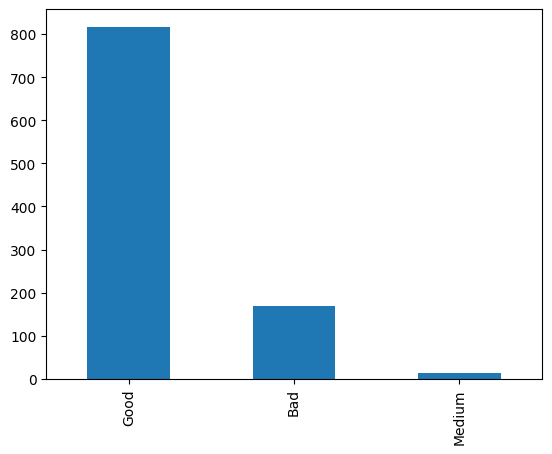

In [136]:
merged_pages["Predicted Quality"].value_counts().plot(kind="bar")


In [137]:
OUTPUT_FILE = DATA_DIR / "results_pages_classification_rescaled.csv"

output_columns = ["page", "text", "Predicted Quality"]

assert (
    not OUTPUT_FILE.exists()
), f"Output file already exists: '{OUTPUT_FILE.absolute()}'"

merged_pages[output_columns].to_csv(OUTPUT_FILE)